# Hierarchical pendulum
Using the position of a pendulum at one point in time from a collection of pendulums on two different planets, determine the values of L, $\theta$, and $a_g$ for each individual pendulum using a hierarchical setup.

In [1]:
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import jax
from jax import random
import matplotlib.pyplot as plt
import jax.numpy as jnp
import arviz as az
import corner
import graphviz

In [152]:
# plotting and analysis utilities
def display_pendulum_data(df):
    color_list = ['#BCF4F5', '#B4EBCA', '#D9F2B4', '#D3FAC7',
                  '#FFB7C3', '#2F2F2F', '#4A4063', '#FE5E41']
    index = 0
    for pend in np.unique(df['pendulum_id']):
        subset = df[df['pendulum_id']==pend]
        plt.plot(subset['time'], subset['pos'],
                    color = color_list[index],
                    label = pend)
        plt.scatter(subset['time'], subset['pos'],
                    color = color_list[index])
        #if pend > 3:
        #    break
        index+=1
    plt.legend()
    plt.xlabel('time [s]')
    plt.ylabel('x position')
    plt.show()

    index = 0
    for planet in np.unique(df['planet_id']):
        subset = df[df['planet_id']==planet]
        plt.plot(subset['time'], subset['pos'],
                    color = color_list[index],
                    label = planet)
        plt.scatter(subset['time'], subset['pos'],
                    color = color_list[index])
        if planet > 3:
            break
        index+=1
    plt.legend()
    plt.xlabel('time [s]')
    plt.ylabel('x position')
    plt.title('pendulums color-coded by planet')
    plt.show()
    
def plot_prior_predictive(prior_pred, variable_model, variable_df, n_steps=10, title = None):
    label = "prior samples"
    plt.hist(
        prior_pred[variable_model].flatten(),
        n_steps,
        #range=(0.2, 3.0),
        #histtype="step",
        color="k",
        lw=0.5,
        alpha=0.5,
        label=label,
        density=True
    )


    plt.hist(df[variable_df], n_steps, histtype="step", color="black", label="data", density=True)
    plt.legend()
    plt.xlabel(variable_model)
    plt.ylabel("density")
    plt.title(title)
    plt.show()

# So because the sampler chain doesn't save the position at each point in time
# i have created a thing that samples position for us
def pos_calculator(L, theta, a_g, sigma, time):
    pos = L * np.sin(theta * np.cos(np.sqrt(a_g / L) * time)) + sigma * np.random.randn(len(time))
    return pos

def how_did_we_do_on_individual_pendulums(df, posterior, n_pendulums, chain_length):
    for number in range(n_pendulums):
        sub_df = df[df['pend_code'] == number]
        print(f"Pendulum number {number}")
        print(f"true L = {np.mean(sub_df['length'].values)}")
        print(f"posterior L = {round(np.median(posterior['L'][:,number]),2)} +/- {round(np.std(posterior['L'][:,number]),2)}")
        print(f"true theta = {np.mean(sub_df['theta'].values)}")
        print(f"posterior theta = {round(np.median(posterior['theta'][:,number]),2)} +/- {round(np.std(posterior['theta'][:,number]),2)}")
        print(f"true a_g = {np.mean(sub_df['a_g'].values)}")
        print(f"posterior a_g = {round(np.median(posterior['a_g'][:,number]),2)} +/- {round(np.std(posterior['a_g'][:,number]),2)}")
        # let's actually draw from this posterior:
        plt.clf()

        
        for j in range(chain_length):
            L = posterior['L'][j,number]
            theta = posterior['theta'][j,number]
            a_g = posterior['a_g'][j,number]#FIXXXXX
            sigma = posterior['σ'][j]
            plt.plot(times, pos_calculator(L,theta,a_g,sigma,times), color = 'grey')
        plt.scatter(sub_df['time'].values, sub_df['pos'].values, zorder=100, color = 'orange')

        plt.show()
def how_did_we_do_on_all_pendulums(df, posterior, n_pendulums, chain_length):
    
    # Plot the intervals from these posteriors for all pendulums at once
    n_pendulums = 8
    chain_length = 2000
    # first do the first four pendulums
    # hots
    colors = ['#F26419', '#F6AE2D', '#820263', '#D90368']
    # colds
    #colors = ['#33658A', '#86BBD8', '#2F4858']
    plt.clf()
    for number in range(4):
        sub_df = df[df['pend_code'] == number]
        # let's actually draw from this posterior:


        y_model = np.zeros((chain_length, len(times)))

        # I need to grab this from the end of the chain (most accurate)
        for j in range(chain_length):
            L = posterior['L'][j,number]
            theta = posterior['theta'][j,number]
            a_g = posterior['a_g'][j,number]#FIXXXXX
            sigma = posterior['σ'][j]
            # Instead of plotting can I combine the lines?
            y_model[j,:] = pos_calculator(L,theta,a_g,sigma,times)
            #if j > 100:
            #    break
        y_average = np.mean(y_model, axis=0)
        y_std = np.std(y_model, axis=0)
        plt.fill_between(times, y_average - 3 * y_std, y_average + 3 * y_std, color=colors[number],
                         alpha=0.5, label='Standard Deviation')
        plt.plot(times, y_average, color = colors[number])
        plt.scatter(sub_df['time'].values, sub_df['pos'].values, zorder=100, color = colors[number])
    plt.title('Pendulums on planet 1')
    plt.show()

    colors = ['#33658A', '#86BBD8', '#2F4858', '#6CC551']
    plt.clf()
    for number in range(4):
        number_2 = number + 3
        sub_df = df[df['pend_code'] == number_2]
        # let's actually draw from this posterior:


        y_model = np.zeros((chain_length, len(times)))

        # I need to grab this from the end of the chain (most accurate)
        for j in range(chain_length):
            L = posterior['L'][j,number_2]
            theta = posterior['theta'][j,number_2]
            a_g = posterior['a_g'][j,number_2]#FIXXXXX
            sigma = posterior['σ'][j]
            # Instead of plotting can I combine the lines?
            y_model[j,:] = pos_calculator(L,theta,a_g,sigma,times)
            #if j > 100:
            #    break
        y_average = np.mean(y_model, axis=0)
        y_std = np.std(y_model, axis=0)
        plt.fill_between(times, y_average - 3 * y_std, y_average + 3 * y_std, color=colors[number],
                         alpha=0.5, label='Standard Deviation')
        plt.plot(times, y_average, color = colors[number])
        plt.scatter(sub_df['time'].values, sub_df['pos'].values, zorder=100, color = colors[number])
    plt.title('Pendulums on planet 2')
    plt.show()


## Hierarchical setup first
I also want an error component (sigma) so we can directly model the overall error; this could eventually become sigma on every individual parameter.


In [74]:



def model(planet_code, pendulum_code, times, pos_obs=None):
    # for every pendulum there are some shared parameters
    # in this case a_g
    #μ_G = numpyro.sample("μ_G", dist.Uniform(1.0,20.0))
    #σ_G = numpyro.sample("σ_G", dist.Uniform(0.0,1))
    
    n_planets = len(np.unique(planet_code))
    n_pendulums = len(np.unique(pendulum_code))

    with numpyro.plate("planet_i", n_planets):
        a_g = numpyro.sample("a_g", dist.Uniform(5, 20))#dist.Normal(μ_G, σ_G))
    
    with numpyro.plate("pend_i", n_pendulums):
        # every pendulum will have their own L, and theta values
        #a_g = numpyro.sample("a_g", dist.Gamma(μ_a_g, σ_a_g))
        L = numpyro.sample("L", dist.Uniform(1,25))
        theta = numpyro.sample("theta", dist.Uniform(0,jnp.pi/2))

    σ = numpyro.sample("σ", dist.Exponential(2))#dist.Uniform(0, 0.1))#dist.HalfNormal(2.0))
    # model is segmented by pendulum
    # time is not independent, does this go here?
    modelx = L[pendulum_code] * jnp.sin(theta[pendulum_code] * jnp.cos(jnp.sqrt(a_g[planet_code] / L[pendulum_code]) * times))
    #pos = numpyro.sample("obs", dist.Normal(modelx, σ), obs=pos_obs)
    # what is the likelihood? what assumptions are made under the hood?
    
    
    with numpyro.plate("data", len(pendulum_code)):
        # this would be like drawing for every data point for a planet
        pos = numpyro.sample("obs", dist.Normal(modelx, σ), obs=pos_obs)

## Now non-hierarchical setup
I guess if this were truly non-hierarchical, you would just be sampling one pendulum?

Here, I'm just deleting the plates over the planets

In [85]:
def nonh_model(pendulum_code, times, pos_obs=None):
    n_pendulums = len(np.unique(pendulum_code))

    with numpyro.plate("pend_i", n_pendulums):
        # every pendulum will have their own a_g, L, and theta values
        a_g = numpyro.sample("a_g", dist.Uniform(5, 20))#dist.Normal(μ_G, σ_G))
        L = numpyro.sample("L", dist.Uniform(1,25))
        theta = numpyro.sample("theta", dist.Uniform(0,jnp.pi/2))

    σ = numpyro.sample("σ", dist.Exponential(2))#dist.HalfNormal(2.0))
    # model is segmented by pendulum
    # time is not independent, does this go here?
    modelx = L[pendulum_code] * jnp.sin(theta[pendulum_code] * jnp.cos(jnp.sqrt(a_g[pendulum_code] / L[pendulum_code]) * times))
    
    #modelx = L[pendulum_code] * jnp.sin(theta * jnp.cos(jnp.sqrt(a_g[pendulum_code] / L[pendulum_code]) * times))
    #pos = numpyro.sample("obs", dist.Normal(modelx, σ), obs=pos_obs)
    
    with numpyro.plate("data", len(pendulum_code)):
        # this would be like drawing for every data point for a planet
        pos = numpyro.sample("obs", dist.Normal(modelx, σ), obs=pos_obs)

## Generate data
To do this make a dataframe and replicate a bunch of columns.

In [127]:
import pandas as pd
# Sample data for the DataFrame
data_params = {
    'length': [10, 15, 13, 12,
               9, 7, 11, 12],
    'theta': [jnp.pi/4, jnp.pi/4, jnp.pi/4, jnp.pi/4,
              jnp.pi/4, jnp.pi/4, jnp.pi/4, jnp.pi/4],
    'a_g': [9, 9, 9, 9, 
            15, 15, 15, 15],
    'pos_err': [0.05, 0.05, 0.05, 0.05,
                0.05, 0.05, 0.05, 0.05],
    'planet_id': [int(0), int(0), int(0), int(0),
                  int(1), int(1), int(1), int(1)]
    
}

# Create the DataFrame
df = pd.DataFrame(data_params)


# Now regenerate each pendulum for multiple moments in time
times = np.linspace(0,10,50)

# Repeat each row in the DataFrame based on the length of the new list
replicated_df = pd.DataFrame(np.repeat(df.values, len(times), axis=0), columns=df.columns)

# Create the new column with values from the new list
replicated_df['time'] = np.tile(times, len(df))
# Create a new column with numerical IDs for each original row
replicated_df['pendulum_id'] = np.repeat(np.arange(len(df)), len(times))

df = replicated_df
df['pos'] = df['length'] * np.sin(df['theta'] * np.cos(np.sqrt(df['a_g'] / df['length']) * df['time'])) + df['pos_err'] * np.random.randn(len(df['time']))

from sklearn.preprocessing import LabelEncoder

pend_encoder = LabelEncoder()
df["pend_code"] = pend_encoder.fit_transform(df["pendulum_id"].values)
planet_encoder = LabelEncoder()
df["planet_code"] = planet_encoder.fit_transform(df["planet_id"].values)

df

length     theta   a_g  pos_err  planet_id       time  pendulum_id  \
0      10.0  0.785398   9.0     0.05        0.0   0.000000            0   
1      10.0  0.785398   9.0     0.05        0.0   0.204082            0   
2      10.0  0.785398   9.0     0.05        0.0   0.408163            0   
3      10.0  0.785398   9.0     0.05        0.0   0.612245            0   
4      10.0  0.785398   9.0     0.05        0.0   0.816327            0   
..      ...       ...   ...      ...        ...        ...          ...   
395    12.0  0.785398  15.0     0.05        1.0   9.183673            7   
396    12.0  0.785398  15.0     0.05        1.0   9.387755            7   
397    12.0  0.785398  15.0     0.05        1.0   9.591837            7   
398    12.0  0.785398  15.0     0.05        1.0   9.795918            7   
399    12.0  0.785398  15.0     0.05        1.0  10.000000            7   

          pos  pend_code  planet_code  
0    7.110520          0            0  
1    6.975840          0            0  
2    6.617184          0            0  
3    6.090078          0            0  
4    5.397631          0            0  
..        ...        ...          ...  
395 -6.071247          7            1  
396 -4.396989          7            1  
397 -2.502523          7            1  
398 -0.400037          7            1  
399  1.676846          7            1  

[400 rows x 10 columns]

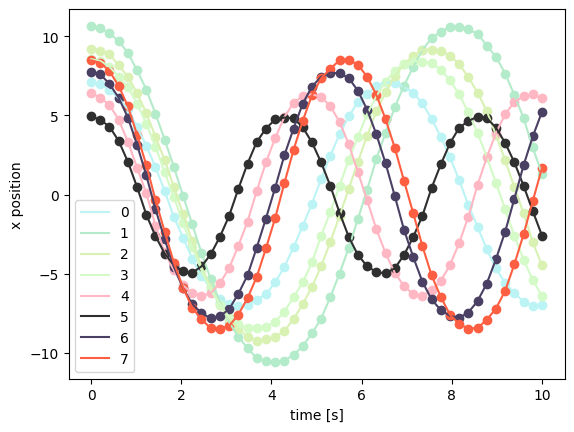

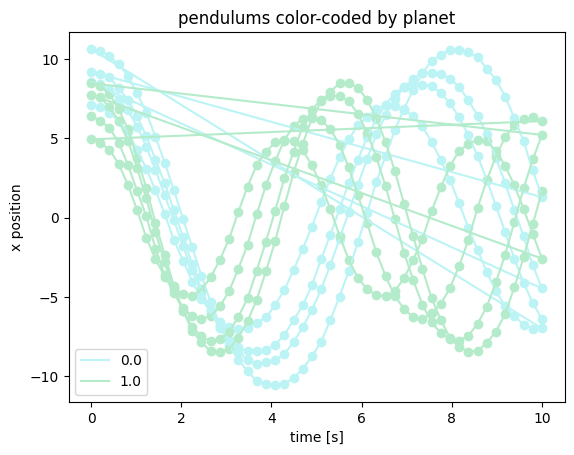

In [128]:
display_pendulum_data(df)

<div class="alert alert-info">
Before running anything, investigate what the prior predictive distribution looks like. This is a way of drawing from the priors that you have set up to see if they are reasonable compared to the data.
</div>

(400,) (400,) (50,)


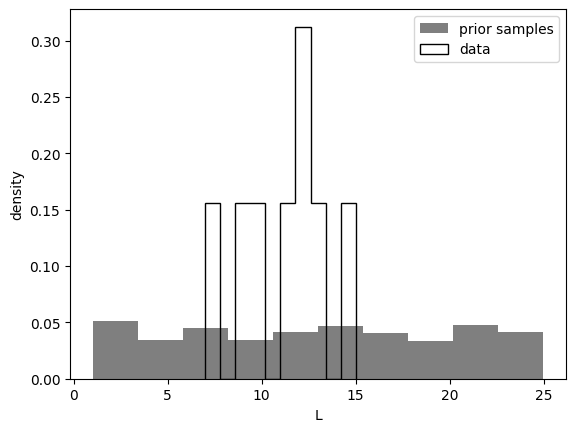

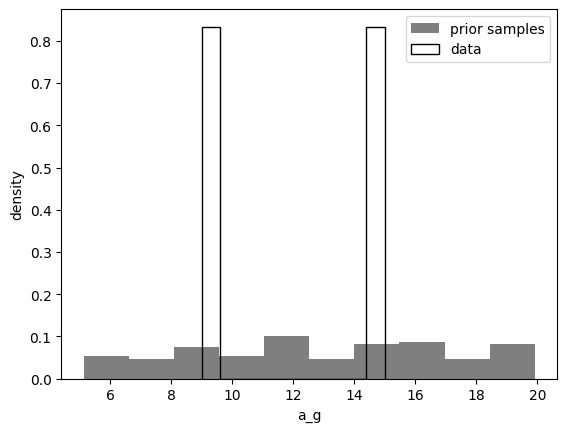

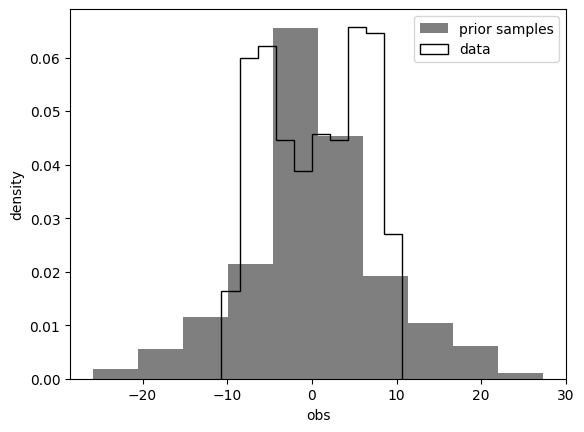

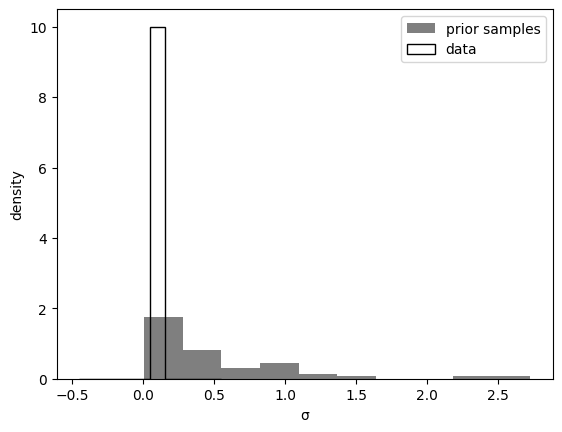

In [110]:
# Generate samples from the prior...

planet_code = df["planet_code"].values
pend_obs = df["pos"].values
time_values = df["time"].values
pend_code = df["pendulum_id"].values

print(np.shape(planet_code), np.shape(pend_code), np.shape(times))
prior_pred = numpyro.infer.Predictive(model, num_samples=50)(
    random.PRNGKey(11), planet_code, pend_code, time_values
)

plot_prior_predictive(prior_pred, "L", "length", n_steps=10, title = None)
plot_prior_predictive(prior_pred, "a_g", "a_g", n_steps=10, title = None)
plot_prior_predictive(prior_pred, "obs", "pos", n_steps=10, title = None)
plot_prior_predictive(prior_pred, "σ", "pos_err", n_steps=10, title = None)


Pendulum number 0
true L = 10.0
posterior L = 11.390000343322754 +/- 6.819999694824219
true theta = 0.7853981633974482
posterior theta = 0.5699999928474426 +/- 0.429999977350235
true a_g = 9.0
posterior a_g = 12.380000114440918 +/- 4.049999713897705


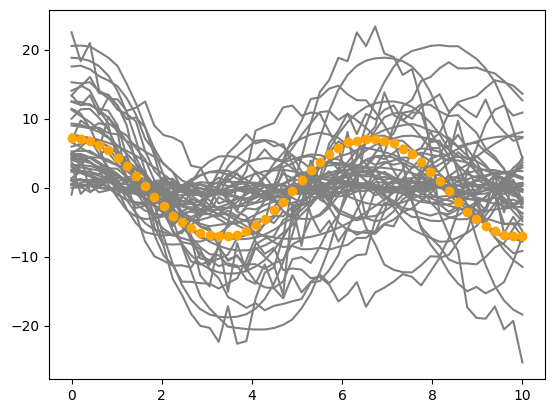

Pendulum number 1
true L = 15.0
posterior L = 10.489999771118164 +/- 7.569999694824219
true theta = 0.7853981633974482
posterior theta = 0.8899999856948853 +/- 0.4399999976158142
true a_g = 9.0
posterior a_g = 14.0 +/- 4.210000038146973


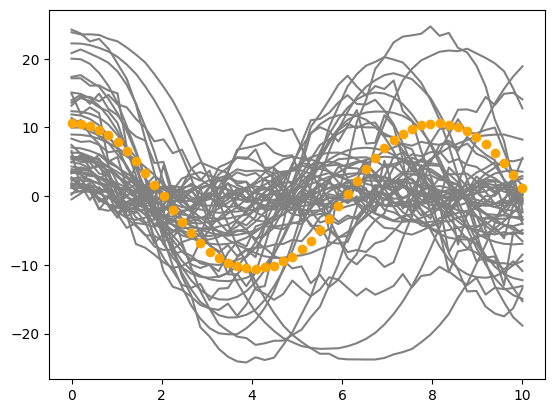

Pendulum number 2
true L = 13.0
posterior L = 14.479999542236328 +/- 7.0
true theta = 0.7853981633974482
posterior theta = 0.6299999952316284 +/- 0.47999998927116394
true a_g = 9.0
posterior a_g = 14.0 +/- 4.210000038146973


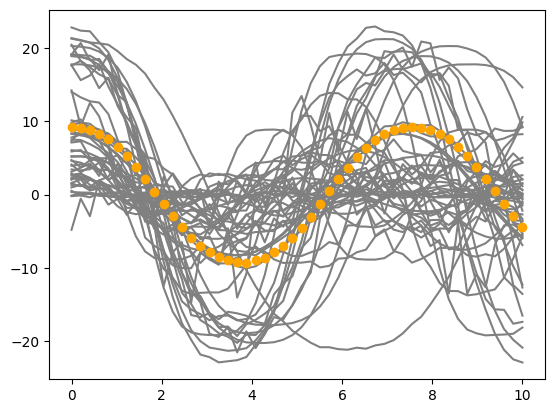

Pendulum number 3
true L = 12.0
posterior L = 11.539999961853027 +/- 6.609999656677246
true theta = 0.7853981633974482
posterior theta = 0.8500000238418579 +/- 0.429999977350235
true a_g = 9.0
posterior a_g = 14.0 +/- 4.210000038146973


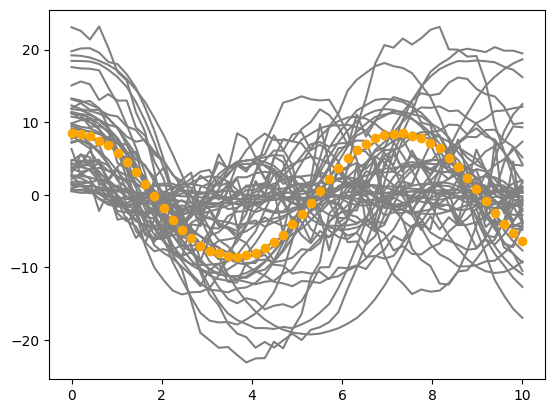

Pendulum number 4
true L = 9.0
posterior L = 14.050000190734863 +/- 7.449999809265137
true theta = 0.7853981633974482
posterior theta = 0.9300000071525574 +/- 0.41999998688697815
true a_g = 15.0
posterior a_g = 14.0 +/- 4.210000038146973


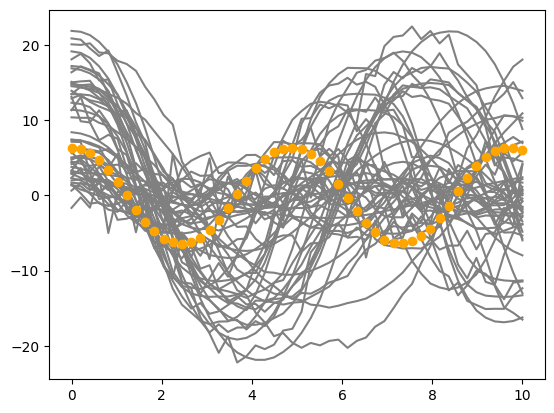

Pendulum number 5
true L = 7.0
posterior L = 13.789999961853027 +/- 7.12999963760376
true theta = 0.7853981633974482
posterior theta = 0.75 +/- 0.4599999785423279
true a_g = 15.0
posterior a_g = 14.0 +/- 4.210000038146973


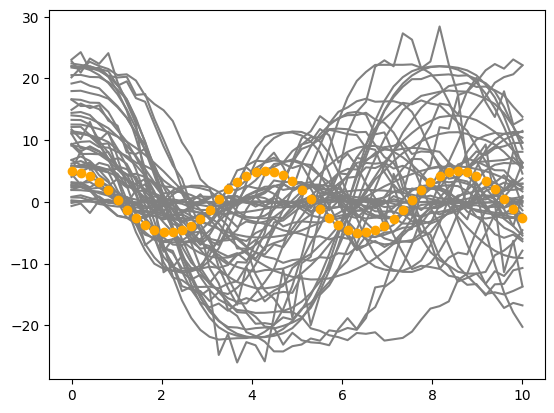

Pendulum number 6
true L = 11.0
posterior L = 13.90999984741211 +/- 6.289999961853027
true theta = 0.7853981633974482
posterior theta = 0.8899999856948853 +/- 0.4899999797344208
true a_g = 15.0
posterior a_g = 14.0 +/- 4.210000038146973


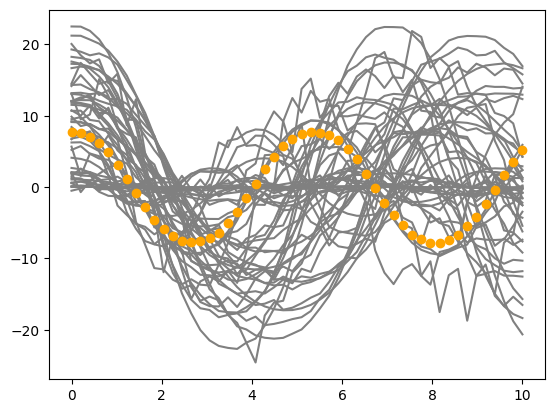

Pendulum number 7
true L = 12.0
posterior L = 12.890000343322754 +/- 6.739999771118164
true theta = 0.7853981633974482
posterior theta = 0.9399999976158142 +/- 0.429999977350235
true a_g = 15.0
posterior a_g = 14.0 +/- 4.210000038146973


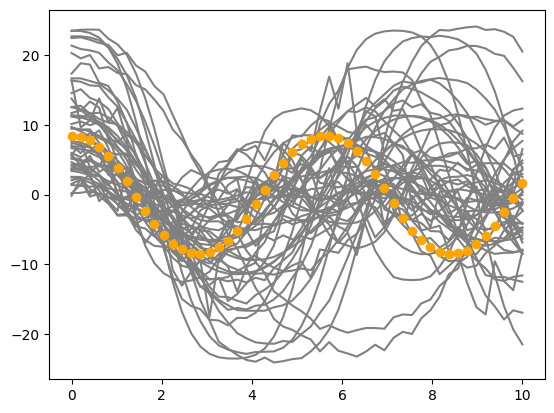

In [111]:
how_did_we_do_on_individual_pendulums(df, prior_pred, 8, 50)


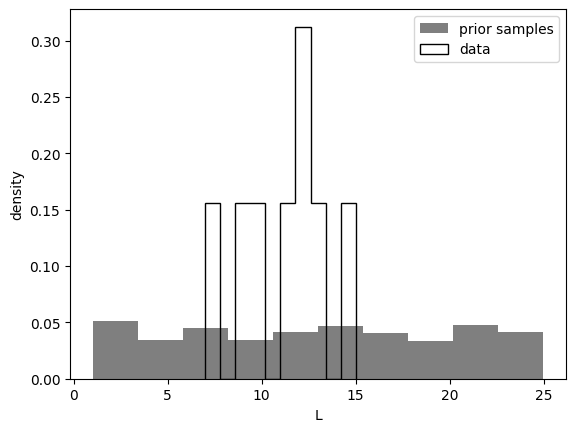

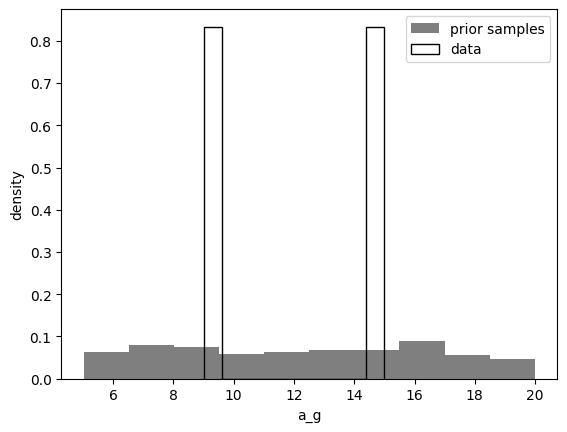

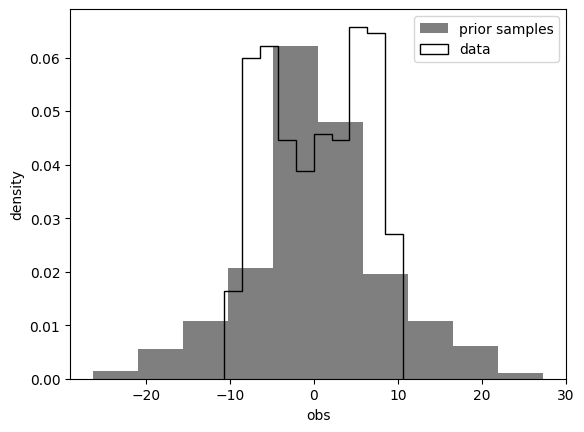

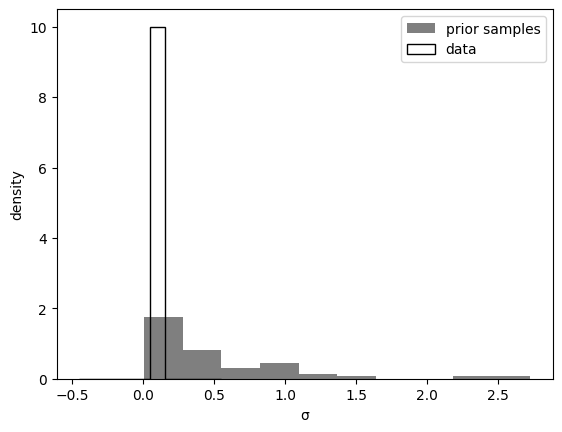

In [112]:
# The same but for the non-hierarchical model
prior_pred_nonh = numpyro.infer.Predictive(nonh_model, num_samples=50)(
    random.PRNGKey(11), pend_code, time_values
)

plot_prior_predictive(prior_pred_nonh, "L", "length", n_steps=10, title = None)
plot_prior_predictive(prior_pred_nonh, "a_g", "a_g", n_steps=10, title = None)
plot_prior_predictive(prior_pred_nonh, "obs", "pos", n_steps=10, title = None)
plot_prior_predictive(prior_pred_nonh, "σ", "pos_err", n_steps=10, title = None)


Pendulum number 0
true L = 10.0
posterior L = 11.390000343322754 +/- 6.819999694824219
true theta = 0.7853981633974482
posterior theta = 0.5699999928474426 +/- 0.429999977350235
true a_g = 9.0
posterior a_g = 11.170000076293945 +/- 3.7799999713897705


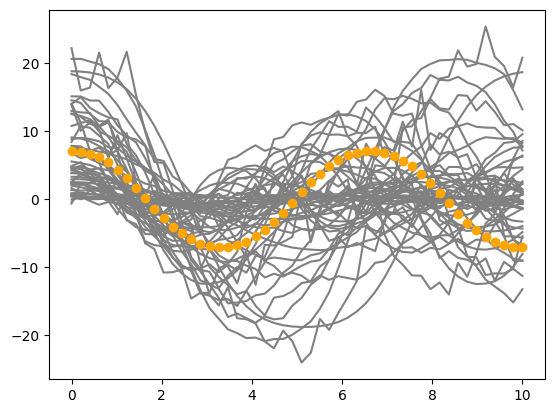

Pendulum number 1
true L = 15.0
posterior L = 10.489999771118164 +/- 7.569999694824219
true theta = 0.7853981633974482
posterior theta = 0.8899999856948853 +/- 0.4399999976158142
true a_g = 9.0
posterior a_g = 13.3100004196167 +/- 3.8999998569488525


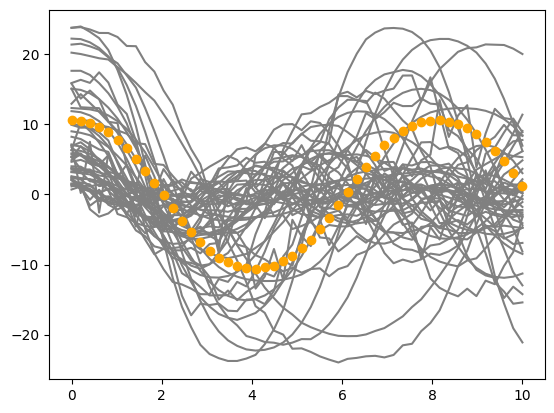

Pendulum number 2
true L = 13.0
posterior L = 14.479999542236328 +/- 7.0
true theta = 0.7853981633974482
posterior theta = 0.6299999952316284 +/- 0.47999998927116394
true a_g = 9.0
posterior a_g = 11.920000076293945 +/- 4.389999866485596


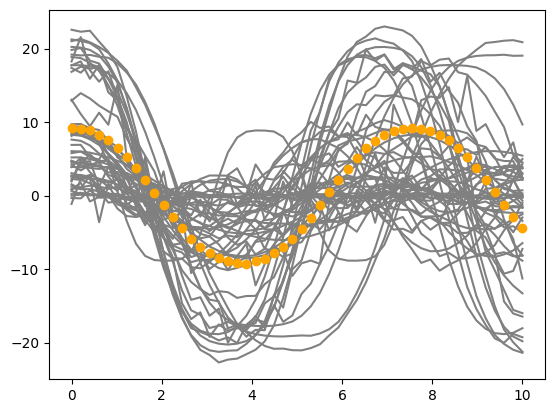

Pendulum number 3
true L = 12.0
posterior L = 11.539999961853027 +/- 6.609999656677246
true theta = 0.7853981633974482
posterior theta = 0.8500000238418579 +/- 0.429999977350235
true a_g = 9.0
posterior a_g = 12.649999618530273 +/- 4.489999771118164


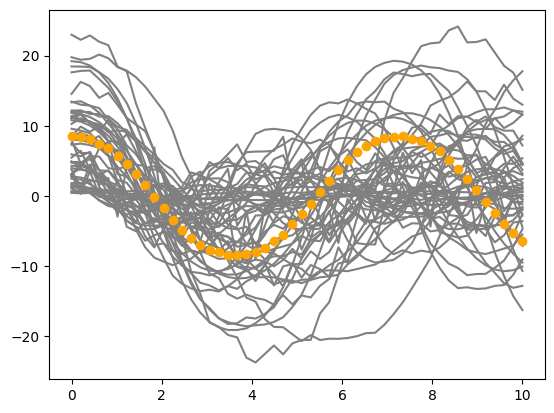

Pendulum number 4
true L = 9.0
posterior L = 14.050000190734863 +/- 7.449999809265137
true theta = 0.7853981633974482
posterior theta = 0.9300000071525574 +/- 0.41999998688697815
true a_g = 15.0
posterior a_g = 13.229999542236328 +/- 4.150000095367432


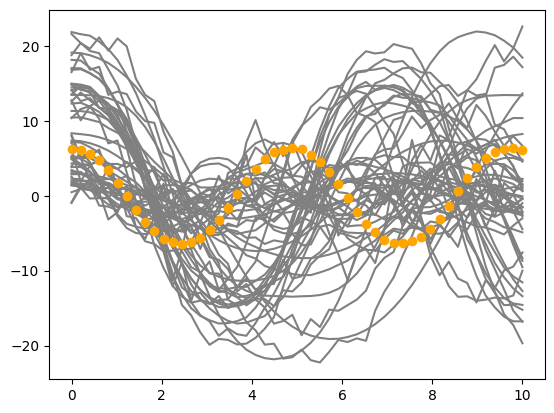

Pendulum number 5
true L = 7.0
posterior L = 13.789999961853027 +/- 7.12999963760376
true theta = 0.7853981633974482
posterior theta = 0.75 +/- 0.4599999785423279
true a_g = 15.0
posterior a_g = 11.600000381469727 +/- 4.179999828338623


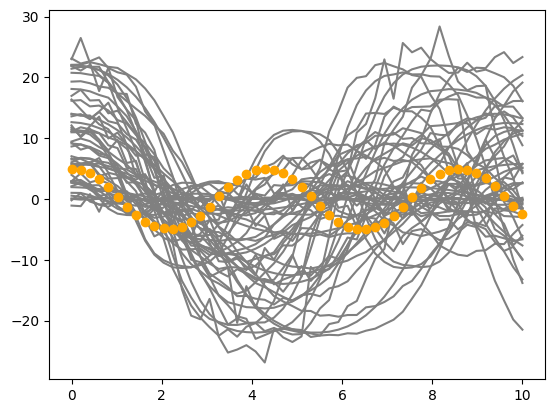

Pendulum number 6
true L = 11.0
posterior L = 13.90999984741211 +/- 6.289999961853027
true theta = 0.7853981633974482
posterior theta = 0.8899999856948853 +/- 0.4899999797344208
true a_g = 15.0
posterior a_g = 12.329999923706055 +/- 4.110000133514404


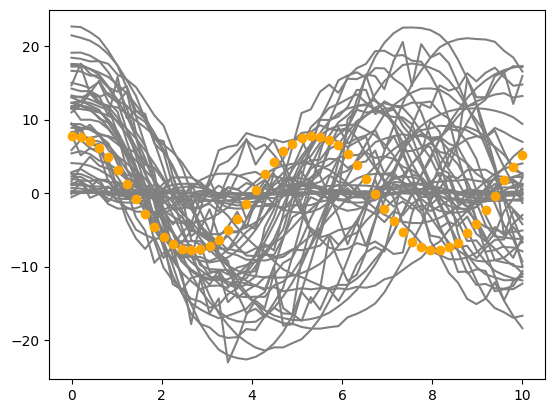

Pendulum number 7
true L = 12.0
posterior L = 12.890000343322754 +/- 6.739999771118164
true theta = 0.7853981633974482
posterior theta = 0.9399999976158142 +/- 0.429999977350235
true a_g = 15.0
posterior a_g = 11.25 +/- 4.059999942779541


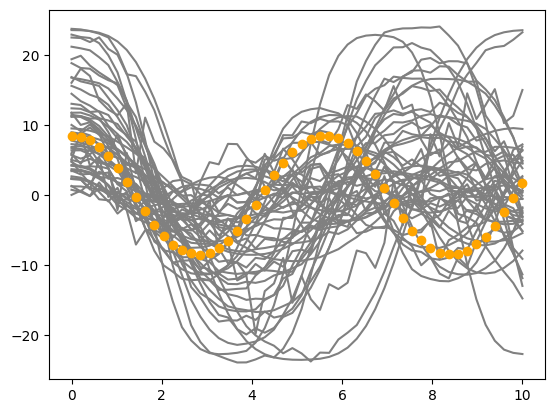

In [113]:
how_did_we_do_on_individual_pendulums(df, prior_pred_nonh, 8, 50)


## Visualize the probabilistic graph
Numpyro has tools for this

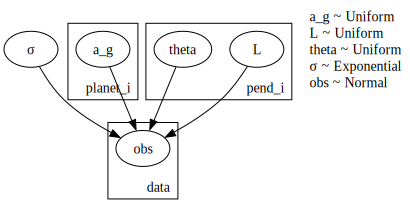

In [114]:
# first hierarchical
numpyro.render_model(
    model=model,
    model_args=(planet_code, pend_code, time_values),
    render_distributions=True,
    render_params=True,
)

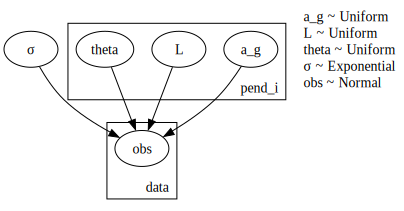

In [115]:
# non-hierarchical
numpyro.render_model(
    model=nonh_model,
    model_args=(pend_code, time_values),
    render_distributions=True,
    render_params=True,
)


## Run the inference for the hierarchical case

In [116]:
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(11)
mcmc.run(rng_key, planet_code, pend_code, time_values, pos_obs=pend_obs)

posterior_samples = mcmc.get_samples()

sample: 100%|█████████████████████████| 4000/4000 [00:24<00:00, 163.46it/s, 175 steps of size 1.42e-02. acc. prob=0.93]


In [117]:
inf_data = az.from_numpyro(mcmc)
az.summary(inf_data)

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
L[0]      10.146  0.095   9.981   10.335      0.006    0.004     250.0   
L[1]      15.210  0.143  14.950   15.480      0.009    0.006     250.0   
L[2]      13.191  0.124  12.974   13.433      0.008    0.006     250.0   
L[3]      12.167  0.114  11.971   12.394      0.007    0.005     252.0   
L[4]       8.998  0.099   8.825    9.182      0.006    0.004     315.0   
L[5]       6.994  0.077   6.857    7.139      0.004    0.003     315.0   
L[6]      11.000  0.121  10.790   11.230      0.007    0.005     314.0   
L[7]      12.002  0.132  11.769   12.249      0.008    0.005     314.0   
a_g[0]     9.126  0.086   8.977    9.295      0.005    0.004     250.0   
a_g[1]    14.994  0.165  14.706   15.304      0.009    0.007     314.0   
theta[0]   0.773  0.009   0.756    0.788      0.001    0.000     255.0   
theta[1]   0.772  0.009   0.757    0.788      0.001    0.000     252.0   
theta[2]   0.773  0.009   0.758    0.789      0.001    0.000     253.0   
theta[3]   0.770  0.009   0.754    0.786      0.001    0.000     252.0   
theta[4]   0.784  0.010   0.766    0.804      0.001    0.000     315.0   
theta[5]   0.785  0.010   0.766    0.804      0.001    0.000     316.0   
theta[6]   0.784  0.010   0.765    0.803      0.001    0.000     317.0   
theta[7]   0.785  0.010   0.767    0.805      0.001    0.000     315.0   
σ          0.051  0.002   0.047    0.054      0.000    0.000     418.0   

          ess_tail  r_hat  
L[0]         358.0    NaN  
L[1]         363.0    NaN  
L[2]         341.0    NaN  
L[3]         344.0    NaN  
L[4]         361.0    NaN  
L[5]         351.0    NaN  
L[6]         355.0    NaN  
L[7]         356.0    NaN  
a_g[0]       340.0    NaN  
a_g[1]       344.0    NaN  
theta[0]     369.0    NaN  
theta[1]     342.0    NaN  
theta[2]     361.0    NaN  
theta[3]     345.0    NaN  
theta[4]     409.0    NaN  
theta[5]     433.0    NaN  
theta[6]     392.0    NaN  
theta[7]     390.0    NaN  
σ            352.0    NaN

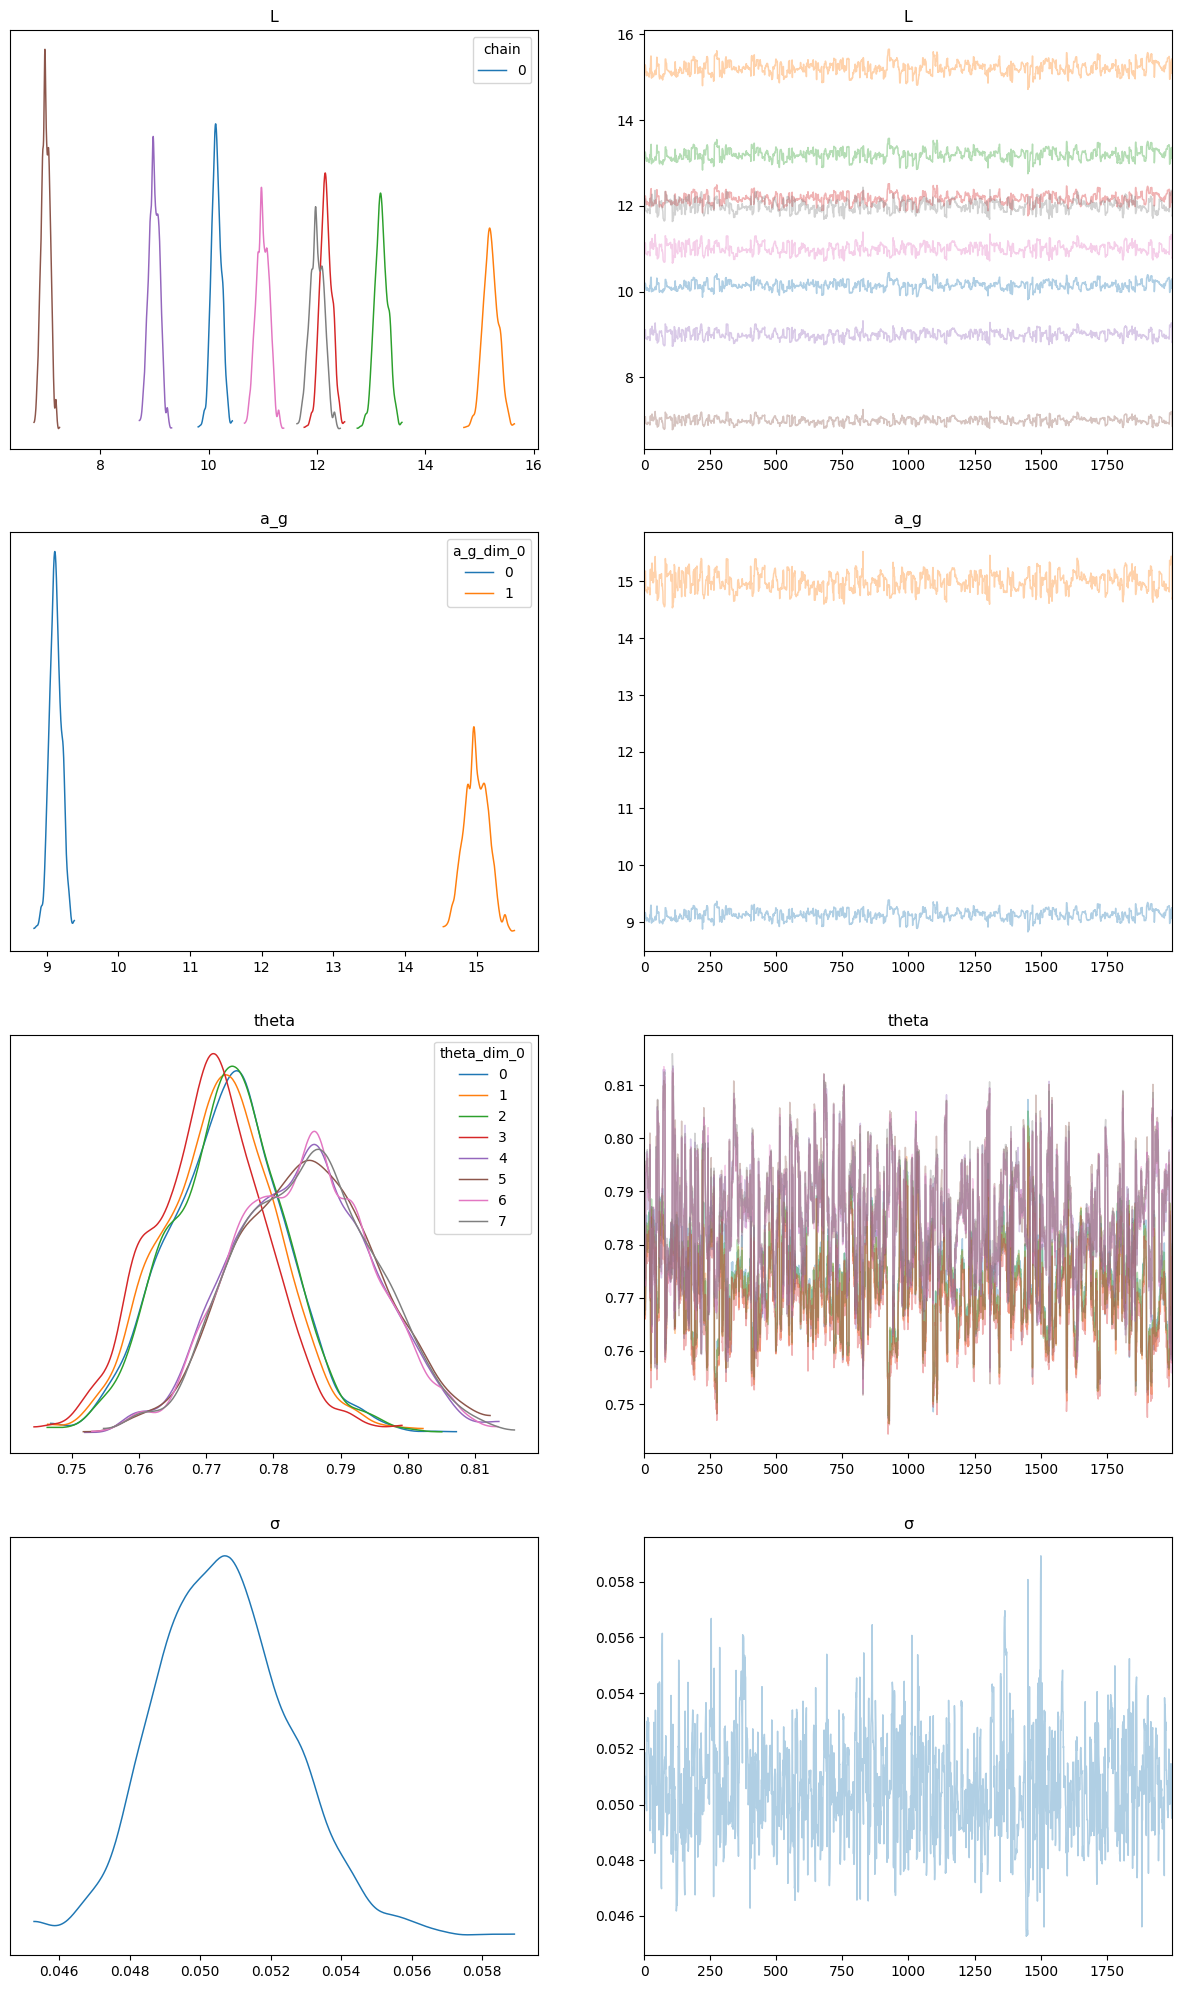

In [119]:
data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True, figsize=(15, 25), legend=True);

## Visualize it
Some of the classic ways to visualize the output don't work super well with a million pendulums

In [120]:
# so there are sampler chains for each group
print('shape of L samples', np.shape(mcmc.get_samples()['L']))
print('shape of a_g samples', np.shape(mcmc.get_samples()['a_g']))

shape of L samples (2000, 8)
shape of a_g samples (2000, 2)


In [121]:
posterior = mcmc.get_samples()
posterior

{'L': Array([[10.122408 , 15.15627  , 13.147047 , ...,  7.0504813, 11.086533 ,
         12.102761 ],
        [10.104297 , 15.161268 , 13.153349 , ...,  7.0526733, 11.087388 ,
         12.10186  ],
        [10.082827 , 15.114674 , 13.106954 , ...,  7.0763135, 11.130464 ,
         12.148025 ],
        ...,
        [10.254178 , 15.382662 , 13.32452  , ...,  7.180091 , 11.301701 ,
         12.327775 ],
        [10.071591 , 15.081985 , 13.101509 , ...,  6.8524566, 10.770825 ,
         11.754118 ],
        [10.078231 , 15.114252 , 13.091497 , ...,  6.857044 , 10.79848  ,
         11.78534  ]], dtype=float32),
 'a_g': Array([[ 9.093926 , 15.118148 ],
        [ 9.096735 , 15.119618 ],
        [ 9.065152 , 15.170328 ],
        ...,
        [ 9.223762 , 15.399592 ],
        [ 9.0583725, 14.683549 ],
        [ 9.06715  , 14.716359 ]], dtype=float32),
 'theta': Array([[0.7753735 , 0.7754873 , 0.7755427 , ..., 0.7806159 , 0.77574295,
         0.777463  ],
        [0.7733952 , 0.77664435, 0.7750633 

Pendulum number 0
true L = 10.0
posterior L = 10.140000343322754 +/- 0.09999999403953552
true theta = 0.7853981633974482
posterior theta = 0.7699999809265137 +/- 0.009999999776482582
true a_g = 9.0
posterior a_g = 9.119999885559082 +/- 0.08999999612569809


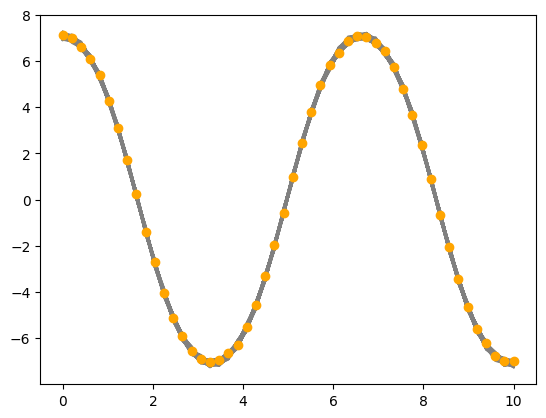

Pendulum number 1
true L = 15.0
posterior L = 15.199999809265137 +/- 0.14000000059604645
true theta = 0.7853981633974482
posterior theta = 0.7699999809265137 +/- 0.009999999776482582
true a_g = 9.0
posterior a_g = 14.989999771118164 +/- 0.17000000178813934


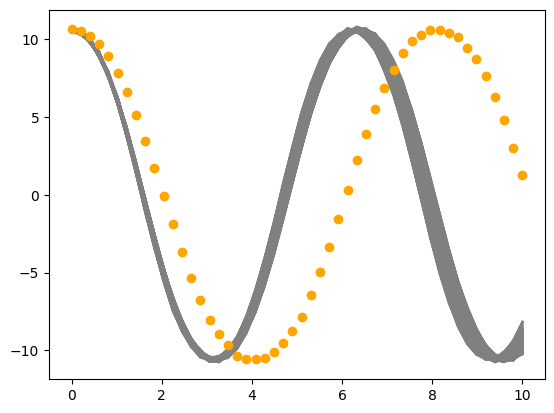

Pendulum number 2
true L = 13.0
posterior L = 13.1899995803833 +/- 0.11999999731779099
true theta = 0.7853981633974482
posterior theta = 0.7699999809265137 +/- 0.009999999776482582
true a_g = 9.0
posterior a_g = 14.989999771118164 +/- 0.17000000178813934


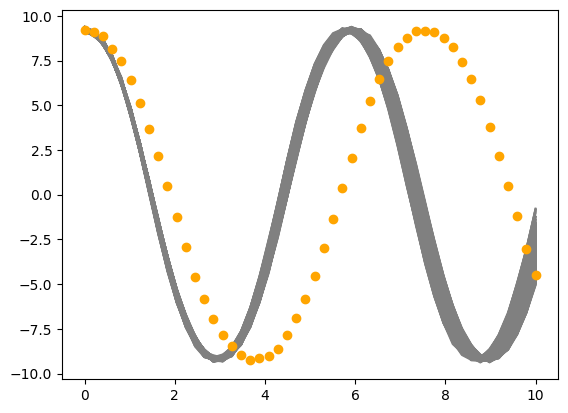

Pendulum number 3
true L = 12.0
posterior L = 12.15999984741211 +/- 0.10999999940395355
true theta = 0.7853981633974482
posterior theta = 0.7699999809265137 +/- 0.009999999776482582
true a_g = 9.0
posterior a_g = 14.989999771118164 +/- 0.17000000178813934


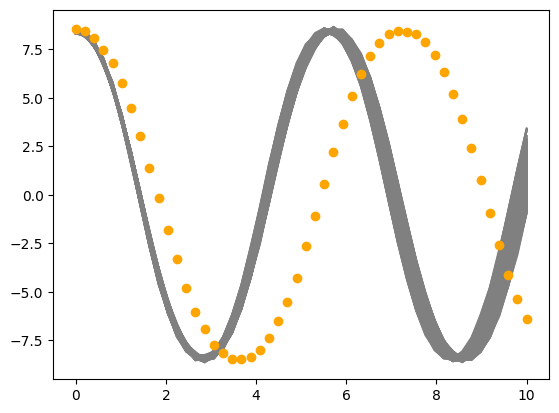

Pendulum number 4
true L = 9.0
posterior L = 8.989999771118164 +/- 0.09999999403953552
true theta = 0.7853981633974482
posterior theta = 0.7799999713897705 +/- 0.009999999776482582
true a_g = 15.0
posterior a_g = 14.989999771118164 +/- 0.17000000178813934


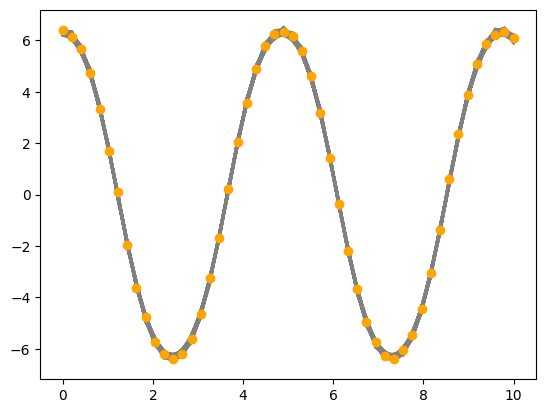

Pendulum number 5
true L = 7.0
posterior L = 6.989999771118164 +/- 0.07999999821186066
true theta = 0.7853981633974482
posterior theta = 0.7799999713897705 +/- 0.009999999776482582
true a_g = 15.0
posterior a_g = 14.989999771118164 +/- 0.17000000178813934


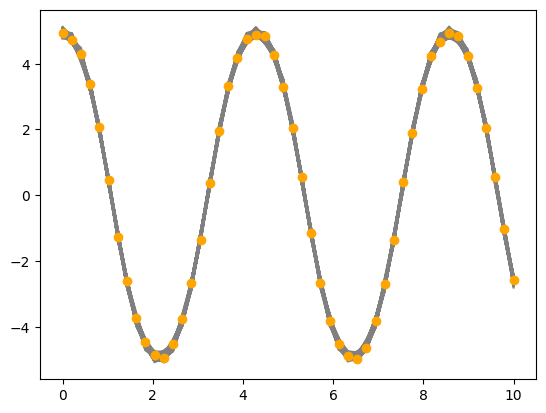

Pendulum number 6
true L = 11.0
posterior L = 10.989999771118164 +/- 0.11999999731779099
true theta = 0.7853981633974482
posterior theta = 0.7799999713897705 +/- 0.009999999776482582
true a_g = 15.0
posterior a_g = 14.989999771118164 +/- 0.17000000178813934


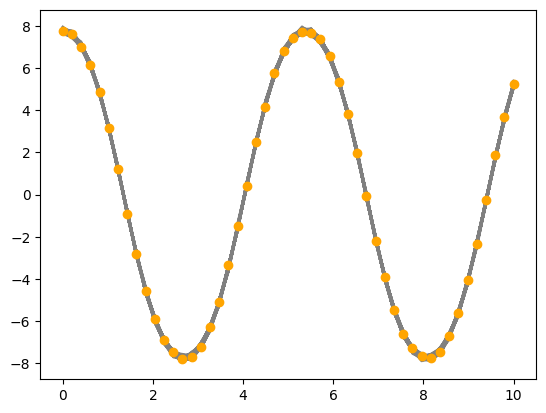

Pendulum number 7
true L = 12.0
posterior L = 11.989999771118164 +/- 0.12999999523162842
true theta = 0.7853981633974482
posterior theta = 0.7900000214576721 +/- 0.009999999776482582
true a_g = 15.0
posterior a_g = 14.989999771118164 +/- 0.17000000178813934


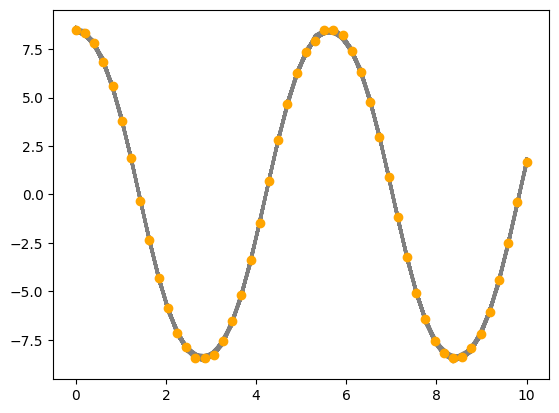

In [153]:
how_did_we_do_on_individual_pendulums(df, posterior, 8, 2000)

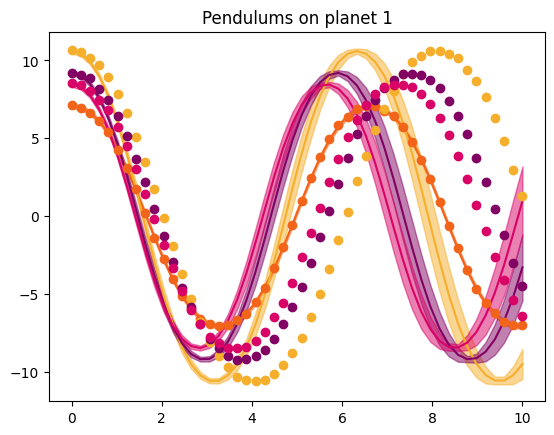

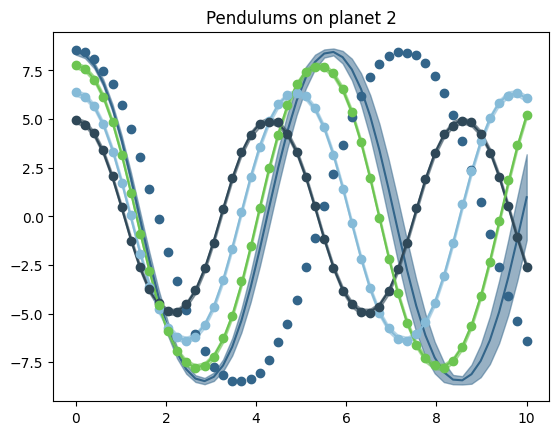

In [155]:
how_did_we_do_on_all_pendulums(df, posterior, 8, 2000)

(2000,)


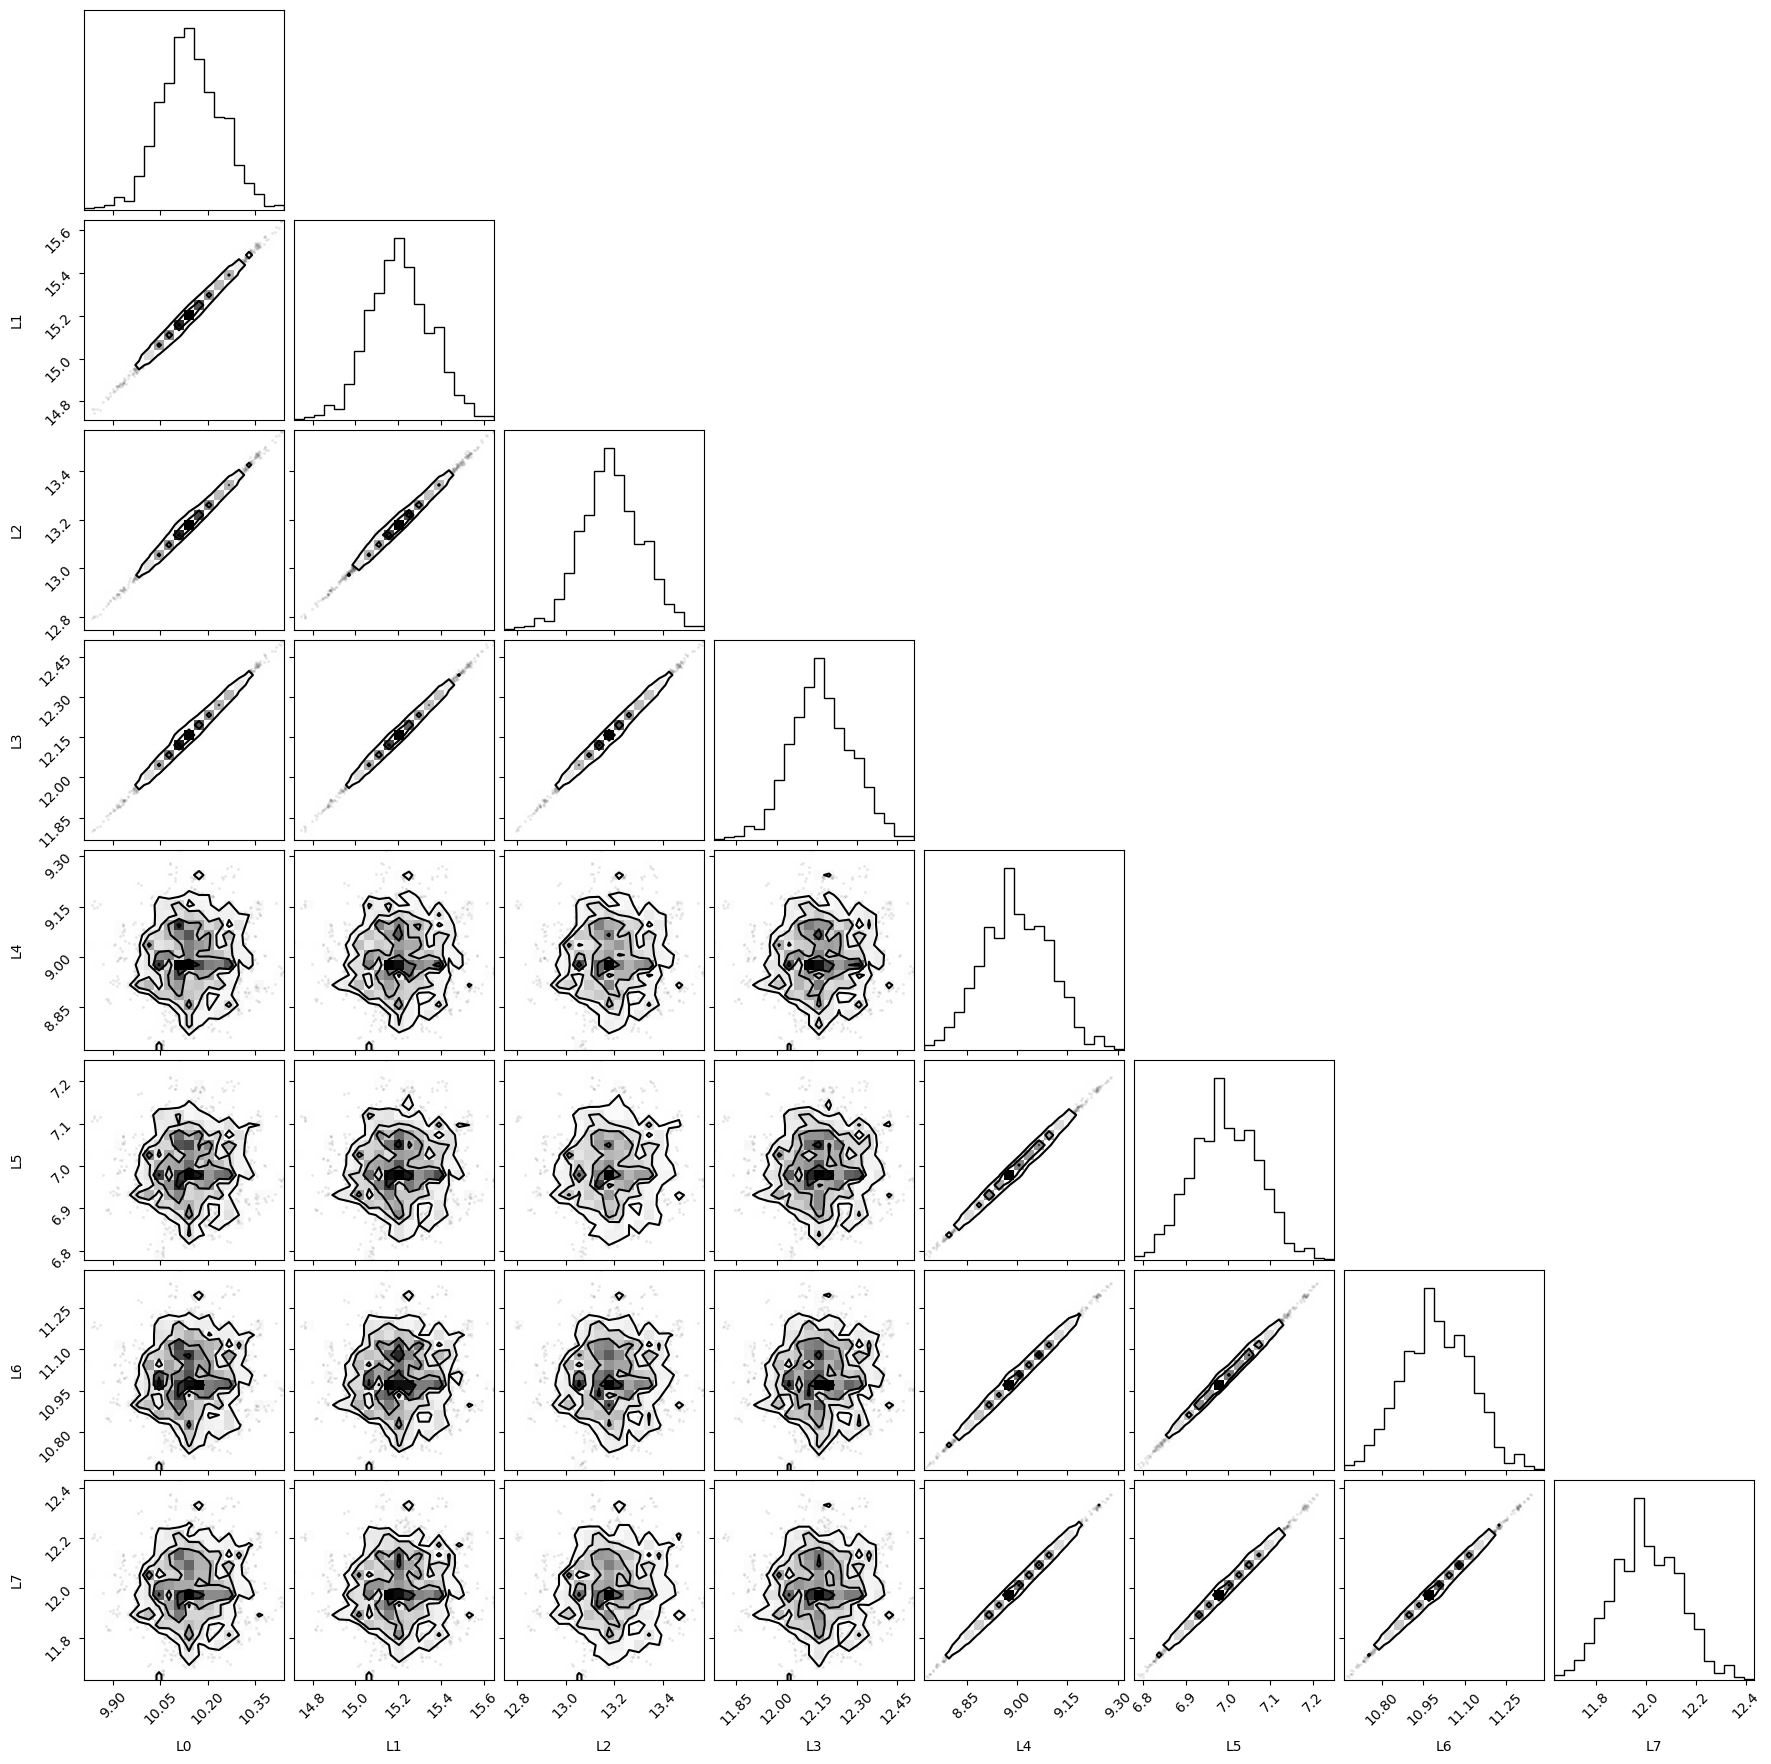

In [124]:
print(np.shape(posterior["L"][:,0]))
data = az.from_dict(
    posterior={"L0": posterior["L"][:,0], "L1": posterior["L"][:,1],
               "L2": posterior["L"][:,2], "L3": posterior["L"][:,3],
               "L4": posterior["L"][:,4], "L5": posterior["L"][:,5],
               "L6": posterior["L"][:,6], "L7": posterior["L"][:,7],
               },
    sample_stats={"diverging": posterior["L"][:,0] < 9.0},
)

figure = corner.corner(data, divergences=True)#,
                       #range = [(5,20),(5,20),(5,20),(5,20),(5,20),(5,20),(5,20),(5,20)])

In [129]:
print(data_params)

{'length': [10, 15, 13, 12, 9, 7, 11, 12], 'theta': [0.7853981633974483, 0.7853981633974483, 0.7853981633974483, 0.7853981633974483, 0.7853981633974483, 0.7853981633974483, 0.7853981633974483, 0.7853981633974483], 'a_g': [9, 9, 9, 9, 15, 15, 15, 15], 'pos_err': [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05], 'planet_id': [0, 0, 0, 0, 1, 1, 1, 1]}


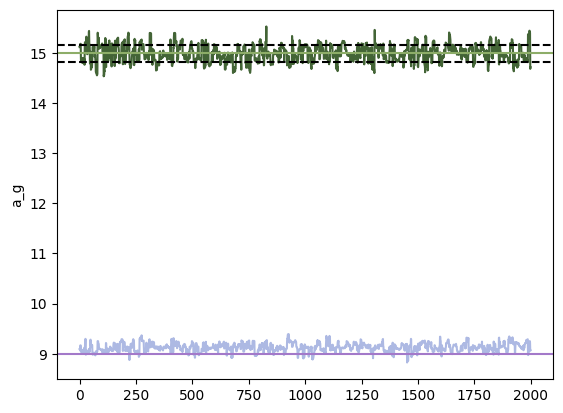

length     theta   a_g  pos_err  planet_id       time  pendulum_id  \
0      10.0  0.785398   9.0     0.05        0.0   0.000000            0   
1      10.0  0.785398   9.0     0.05        0.0   0.204082            0   
2      10.0  0.785398   9.0     0.05        0.0   0.408163            0   
3      10.0  0.785398   9.0     0.05        0.0   0.612245            0   
4      10.0  0.785398   9.0     0.05        0.0   0.816327            0   
..      ...       ...   ...      ...        ...        ...          ...   
395    12.0  0.785398  15.0     0.05        1.0   9.183673            7   
396    12.0  0.785398  15.0     0.05        1.0   9.387755            7   
397    12.0  0.785398  15.0     0.05        1.0   9.591837            7   
398    12.0  0.785398  15.0     0.05        1.0   9.795918            7   
399    12.0  0.785398  15.0     0.05        1.0  10.000000            7   

          pos  pend_code  planet_code  
0    7.110520          0            0  
1    6.975840          0            0  
2    6.617184          0            0  
3    6.090078          0            0  
4    5.397631          0            0  
..        ...        ...          ...  
395 -6.071247          7            1  
396 -4.396989          7            1  
397 -2.502523          7            1  
398 -0.400037          7            1  
399  1.676846          7            1  

[400 rows x 10 columns]

In [131]:
plt.clf()
plt.plot(mcmc.get_samples()['a_g'][:,1], color = '#436436')
plt.axhline(y = np.mean(df[df['planet_code'] == 1]['a_g']), color = '#8DAD68')
plt.axhline(y = np.mean(mcmc.get_samples()['a_g'][:,1]) - np.std(mcmc.get_samples()['a_g'][:,1]), 
            color = 'black', ls = '--')
plt.axhline(y = np.mean(mcmc.get_samples()['a_g'][:,1]) + np.std(mcmc.get_samples()['a_g'][:,1]), 
            color = 'black', ls = '--')

plt.ylabel('a_g')

plt.plot(mcmc.get_samples()['a_g'][:,0], color = '#ADB9E3')
plt.axhline(y = np.mean(df[df['planet_code'] == 0]['a_g']), color = '#A379C9')
plt.ylabel('a_g')
plt.show()
df

## Now run the inference for the non-hierarchical case

In [133]:
nuts_kernel_nonh = NUTS(nonh_model)

mcmc_nonh = MCMC(nuts_kernel_nonh, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(11)
mcmc_nonh.run(rng_key, pend_code, time_values, pos_obs=pend_obs)


sample: 100%|█████████████████████████| 4000/4000 [01:35<00:00, 42.04it/s, 1023 steps of size 8.61e-03. acc. prob=0.91]


In [134]:
inf_data_nonh = az.from_numpyro(mcmc_nonh)
az.summary(inf_data_nonh)

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
L[0]      10.107  0.223   9.703   10.560      0.006    0.004    1500.0   
L[1]      15.214  0.230  14.805   15.654      0.006    0.004    1590.0   
L[2]      13.520  0.240  13.091   13.957      0.007    0.005    1214.0   
L[3]      11.930  0.213  11.526   12.312      0.006    0.004    1488.0   
L[4]       9.125  0.241   8.739    9.653      0.007    0.005    1255.0   
L[5]       7.062  0.224   6.642    7.461      0.006    0.005    1256.0   
L[6]      11.010  0.214  10.589   11.392      0.006    0.004    1370.0   
L[7]      11.957  0.203  11.624   12.396      0.005    0.004    1414.0   
a_g[0]     9.091  0.201   8.712    9.488      0.005    0.004    1503.0   
a_g[1]     9.129  0.137   8.886    9.394      0.003    0.002    1592.0   
a_g[2]     9.354  0.166   9.053    9.651      0.005    0.003    1211.0   
a_g[3]     8.948  0.160   8.636    9.229      0.004    0.003    1495.0   
a_g[4]    15.207  0.401  14.525   16.051      0.012    0.008    1252.0   
a_g[5]    15.139  0.480  14.226   15.987      0.014    0.010    1253.0   
a_g[6]    15.009  0.292  14.453   15.549      0.008    0.006    1370.0   
a_g[7]    14.939  0.253  14.501   15.467      0.007    0.005    1414.0   
theta[0]   0.777  0.020   0.737    0.815      0.001    0.000    1500.0   
theta[1]   0.772  0.014   0.746    0.797      0.000    0.000    1594.0   
theta[2]   0.751  0.015   0.723    0.779      0.000    0.000    1221.0   
theta[3]   0.789  0.017   0.758    0.820      0.000    0.000    1479.0   
theta[4]   0.772  0.024   0.722    0.812      0.001    0.000    1253.0   
theta[5]   0.777  0.029   0.722    0.829      0.001    0.001    1246.0   
theta[6]   0.784  0.018   0.748    0.815      0.000    0.000    1370.0   
theta[7]   0.789  0.016   0.755    0.815      0.000    0.000    1422.0   
σ          0.051  0.002   0.047    0.054      0.000    0.000    2731.0   

          ess_tail  r_hat  
L[0]        1168.0    NaN  
L[1]        1410.0    NaN  
L[2]        1010.0    NaN  
L[3]        1117.0    NaN  
L[4]         974.0    NaN  
L[5]        1171.0    NaN  
L[6]        1315.0    NaN  
L[7]        1100.0    NaN  
a_g[0]      1168.0    NaN  
a_g[1]      1410.0    NaN  
a_g[2]      1008.0    NaN  
a_g[3]      1117.0    NaN  
a_g[4]       974.0    NaN  
a_g[5]      1143.0    NaN  
a_g[6]      1315.0    NaN  
a_g[7]      1112.0    NaN  
theta[0]    1246.0    NaN  
theta[1]    1389.0    NaN  
theta[2]     992.0    NaN  
theta[3]    1189.0    NaN  
theta[4]     978.0    NaN  
theta[5]    1163.0    NaN  
theta[6]    1325.0    NaN  
theta[7]    1125.0    NaN  
σ           1053.0    NaN

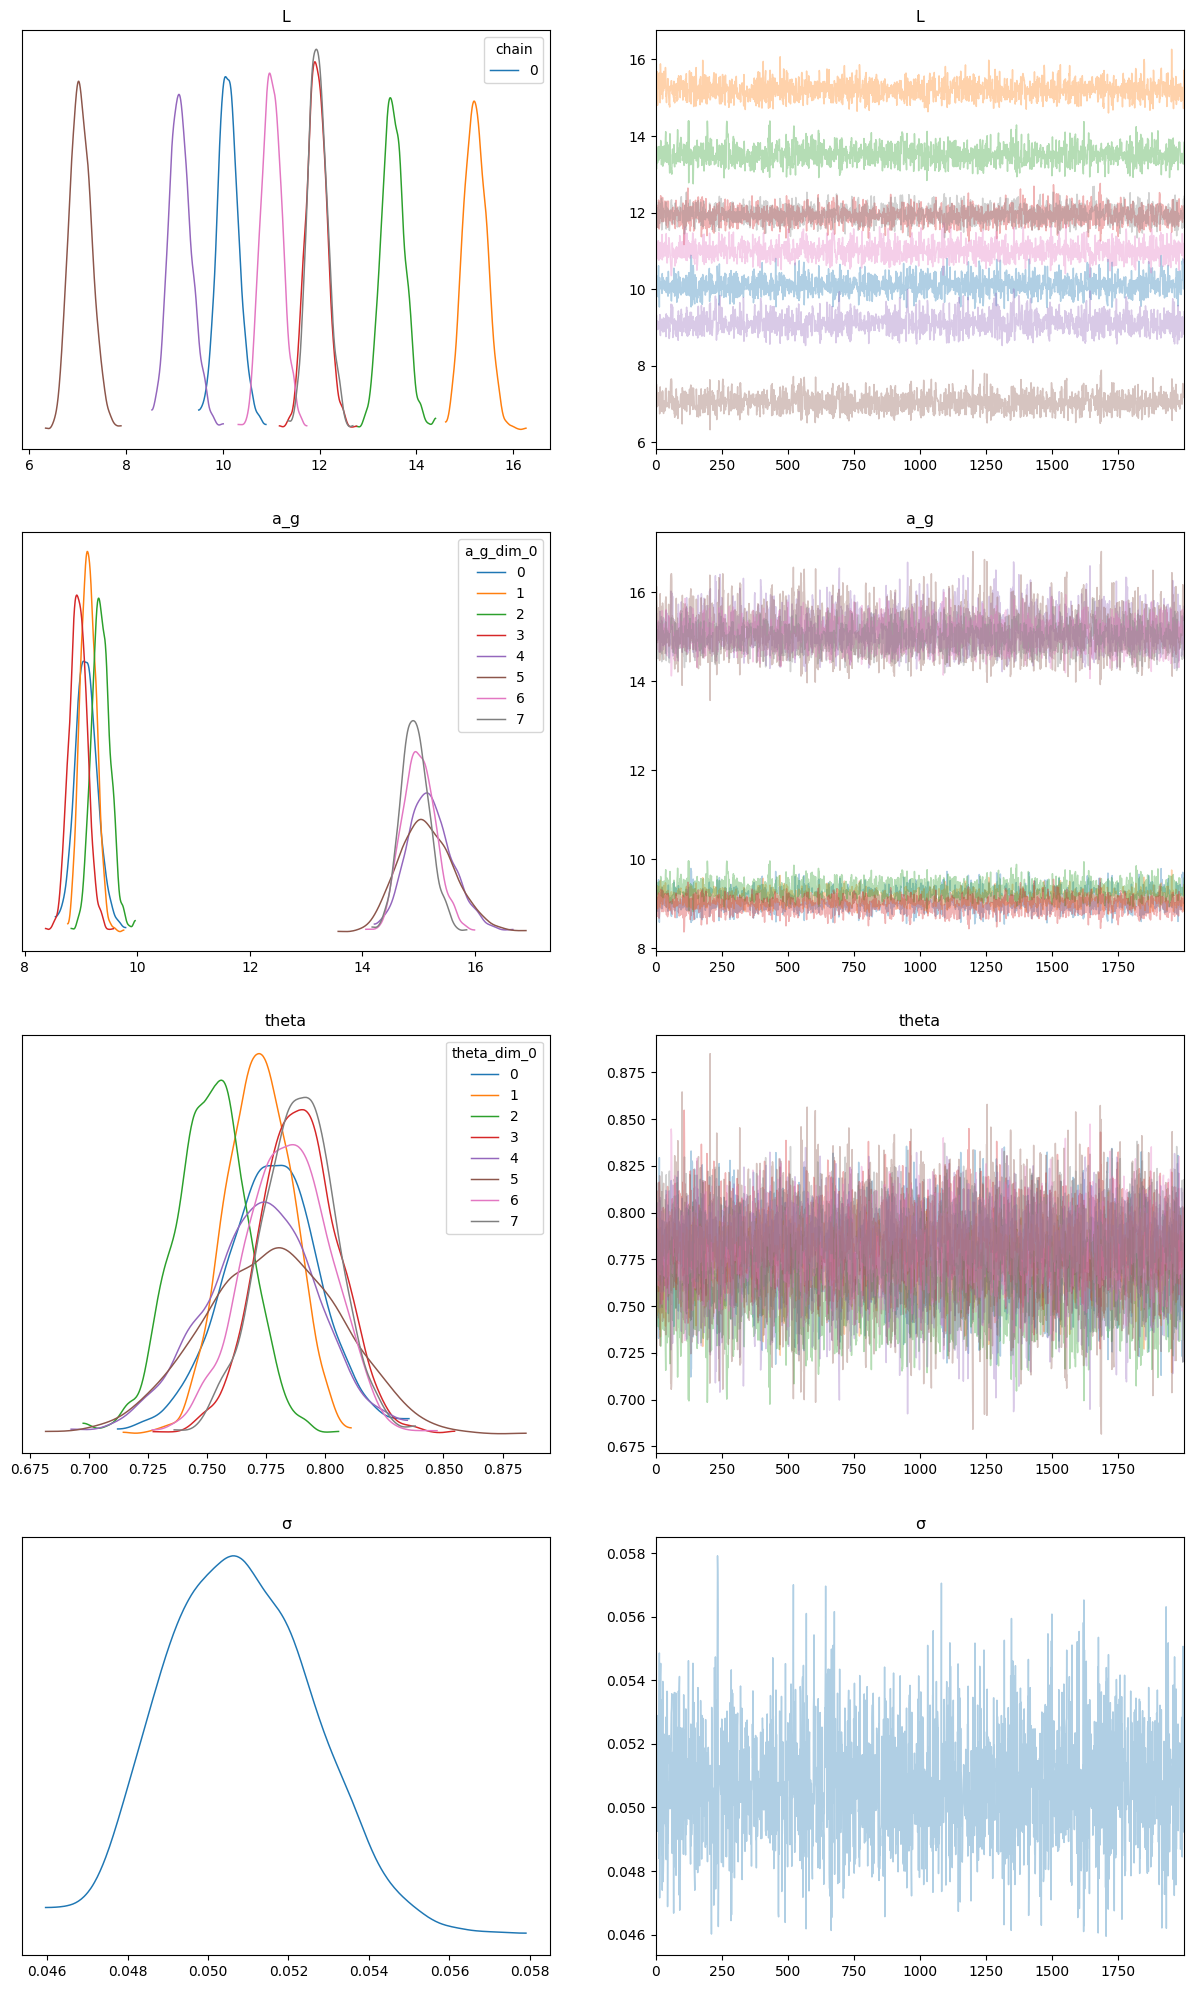

In [135]:
data_nonh = az.from_numpyro(mcmc_nonh)
az.plot_trace(data_nonh, compact=True, figsize=(15, 25), legend=True);

In [104]:
posterior_nonh = mcmc_nonh.get_samples()
posterior_nonh

{'L': Array([[12.7571945, 14.556763 ,  2.4638424, ...,  4.54231  ,  9.527952 ,
         13.370428 ],
        [ 9.944965 , 14.018368 ,  6.2731414, ...,  6.047586 , 12.429341 ,
         13.742586 ],
        [16.789808 , 14.900406 ,  5.2574043, ...,  8.050844 , 11.824578 ,
         10.497811 ],
        ...,
        [12.8820095, 24.392405 ,  8.318384 , ...,  6.162576 , 12.754934 ,
         11.725657 ],
        [12.8820095, 24.392405 ,  8.318384 , ...,  6.162576 , 12.754934 ,
         11.725657 ],
        [12.8820095, 24.392405 ,  8.318384 , ...,  6.162576 , 12.754934 ,
         11.725657 ]], dtype=float32),
 'a_g': Array([[13.883306, 10.711358,  6.995494, ...,  9.738674, 13.133908,
         16.62566 ],
        [10.866717, 10.21798 , 18.717236, ..., 12.932658, 17.11905 ,
         16.82879 ],
        [18.141901, 10.910487, 15.767871, ..., 17.07974 , 15.944375,
         13.328722],
        ...,
        [14.024857, 17.91259 ,  7.052656, ..., 13.259877, 17.40447 ,
         14.598632],
        [

Pendulum number 0
true L = 10.0
posterior L = 10.140000343322754 +/- 0.09999999403953552
true theta = 0.7853981633974482
posterior theta = 0.7699999809265137 +/- 0.009999999776482582
true a_g = 9.0
posterior a_g = 9.119999885559082 +/- 0.08999999612569809


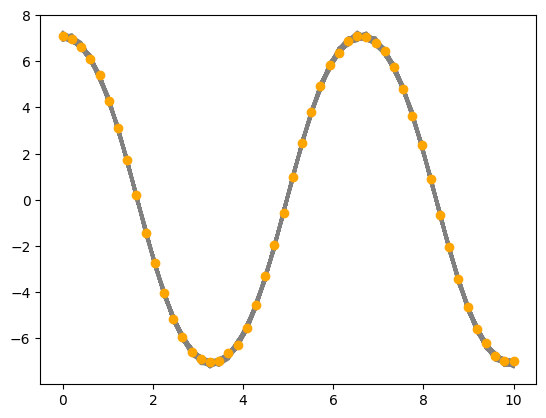

Pendulum number 1
true L = 15.0
posterior L = 15.199999809265137 +/- 0.14000000059604645
true theta = 0.7853981633974482
posterior theta = 0.7699999809265137 +/- 0.009999999776482582
true a_g = 9.0
posterior a_g = 14.989999771118164 +/- 0.17000000178813934


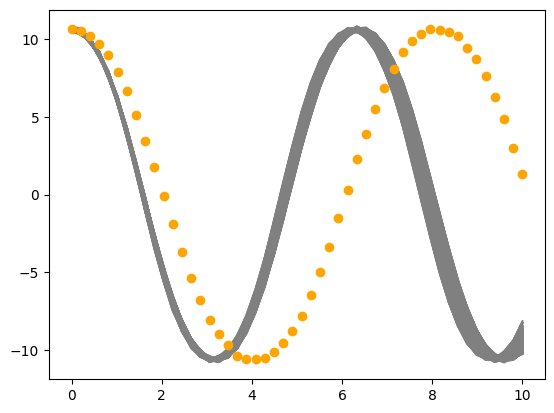

Pendulum number 2
true L = 13.0
posterior L = 13.1899995803833 +/- 0.11999999731779099
true theta = 0.7853981633974482
posterior theta = 0.7699999809265137 +/- 0.009999999776482582
true a_g = 9.0
posterior a_g = 14.989999771118164 +/- 0.17000000178813934


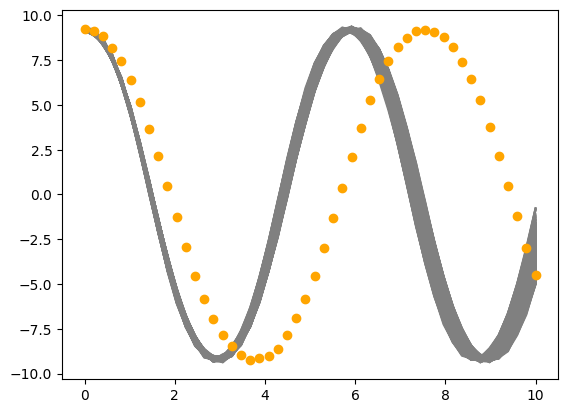

Pendulum number 3
true L = 12.0
posterior L = 12.15999984741211 +/- 0.10999999940395355
true theta = 0.7853981633974482
posterior theta = 0.7699999809265137 +/- 0.009999999776482582
true a_g = 9.0
posterior a_g = 14.989999771118164 +/- 0.17000000178813934


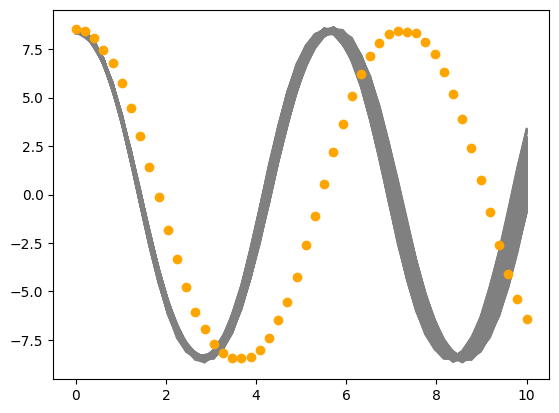

Pendulum number 4
true L = 9.0
posterior L = 8.989999771118164 +/- 0.09999999403953552
true theta = 0.7853981633974482
posterior theta = 0.7799999713897705 +/- 0.009999999776482582
true a_g = 15.0
posterior a_g = 14.989999771118164 +/- 0.17000000178813934


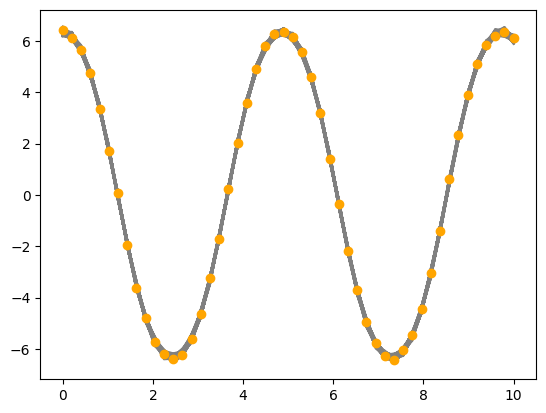

Pendulum number 5
true L = 7.0
posterior L = 6.989999771118164 +/- 0.07999999821186066
true theta = 0.7853981633974482
posterior theta = 0.7799999713897705 +/- 0.009999999776482582
true a_g = 15.0
posterior a_g = 14.989999771118164 +/- 0.17000000178813934


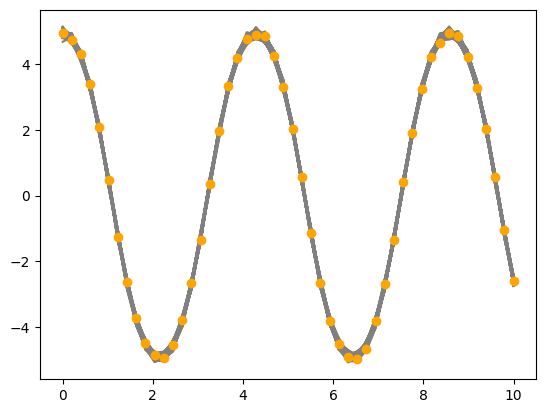

Pendulum number 6
true L = 11.0
posterior L = 10.989999771118164 +/- 0.11999999731779099
true theta = 0.7853981633974482
posterior theta = 0.7799999713897705 +/- 0.009999999776482582
true a_g = 15.0
posterior a_g = 14.989999771118164 +/- 0.17000000178813934


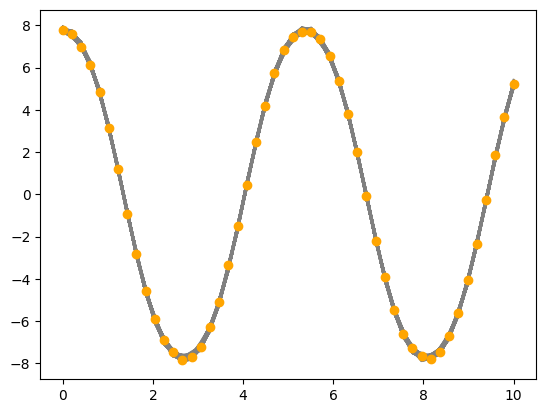

Pendulum number 7
true L = 12.0
posterior L = 11.989999771118164 +/- 0.12999999523162842
true theta = 0.7853981633974482
posterior theta = 0.7900000214576721 +/- 0.009999999776482582
true a_g = 15.0
posterior a_g = 14.989999771118164 +/- 0.17000000178813934


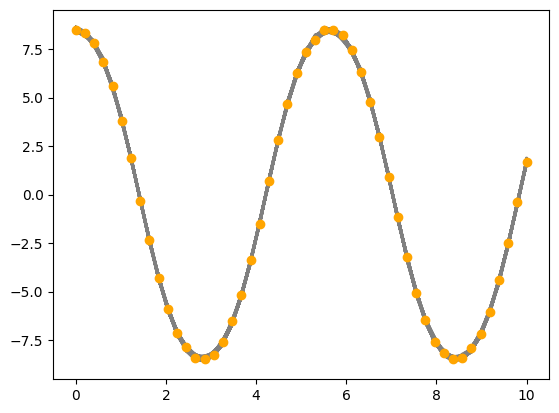

In [158]:
how_did_we_do_on_individual_pendulums(df, posterior, 8, 2000)

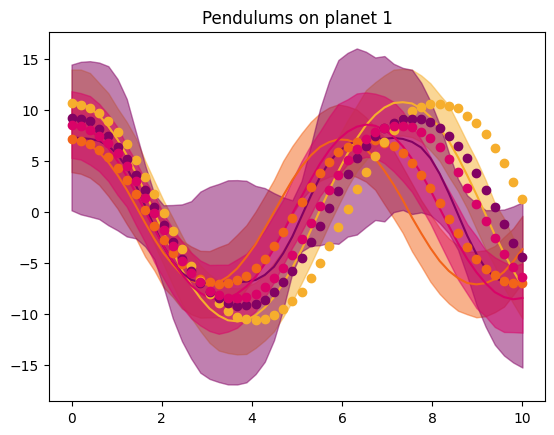

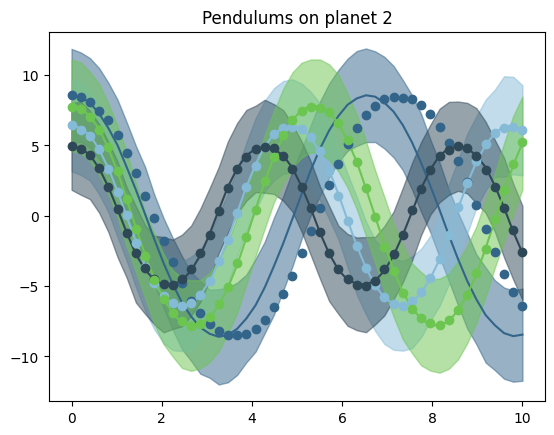

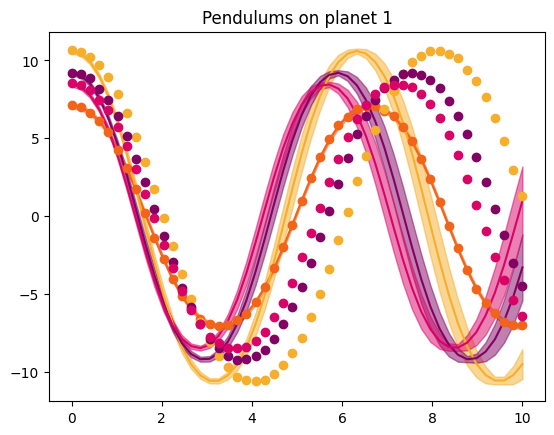

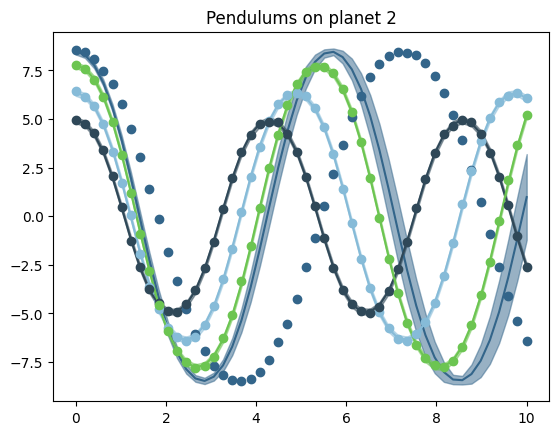

In [156]:
how_did_we_do_on_all_pendulums(df, posterior_nonh, 8, 2000)
how_did_we_do_on_all_pendulums(df, posterior, 8, 2000)

(2000,)


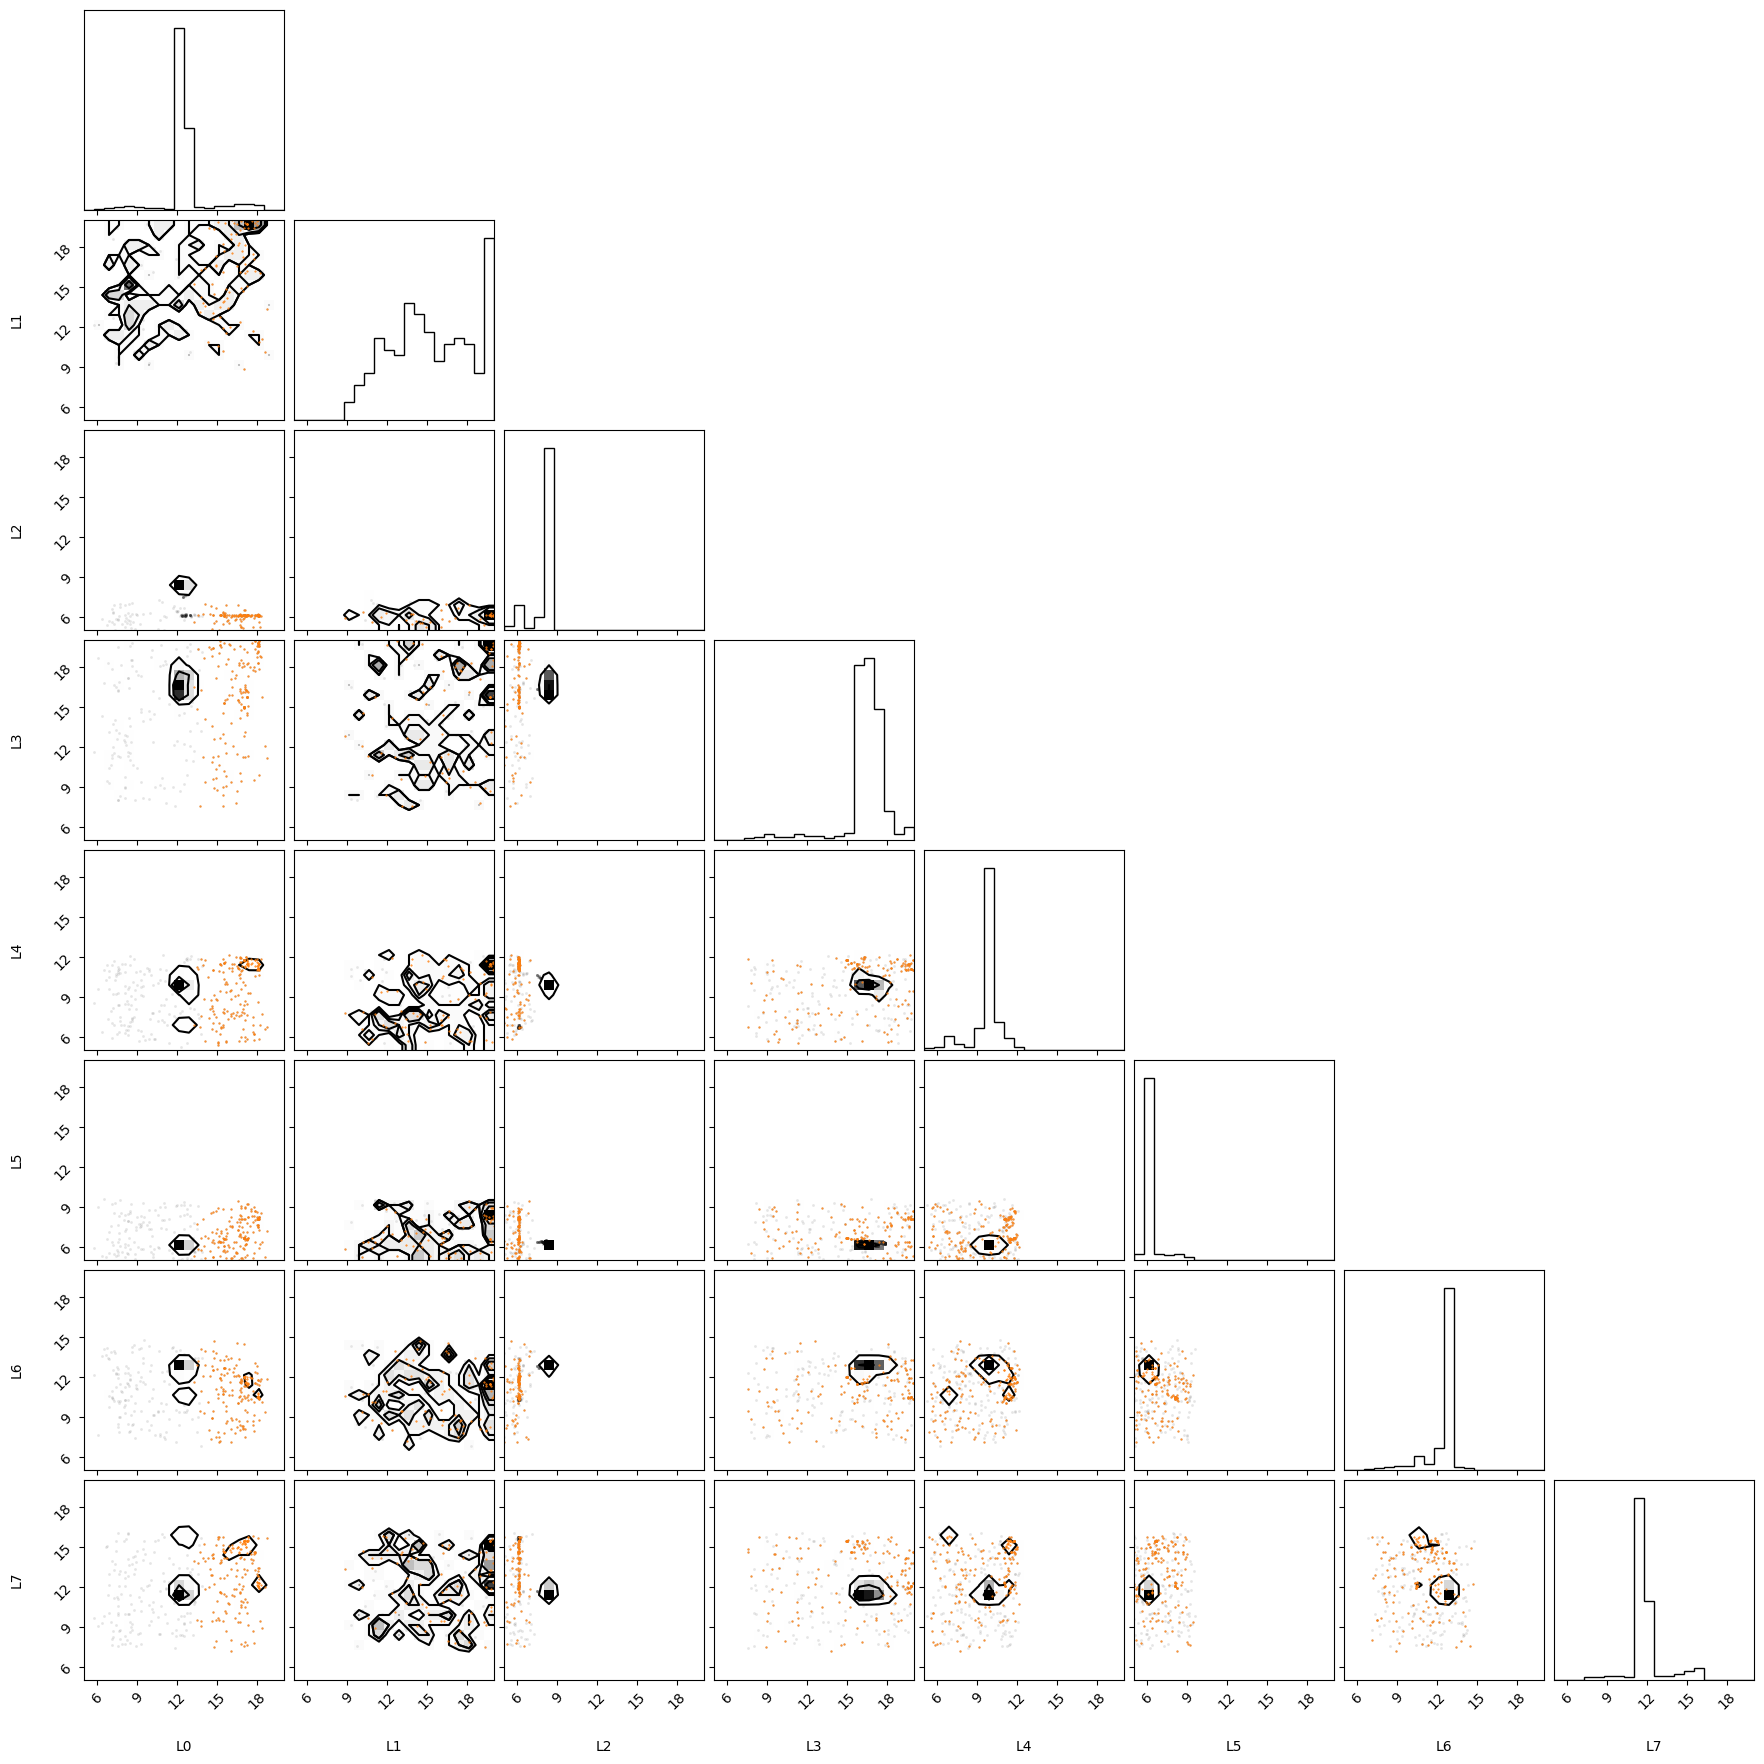

In [138]:
print(np.shape(posterior_nonh["L"][:,0]))
data = az.from_dict(
    posterior={"L0": posterior_nonh["L"][:,0], "L1": posterior_nonh["L"][:,1],
               "L2": posterior_nonh["L"][:,2], "L3": posterior_nonh["L"][:,3],
               "L4": posterior_nonh["L"][:,4], "L5": posterior_nonh["L"][:,5],
               "L6": posterior_nonh["L"][:,6], "L7": posterior_nonh["L"][:,7],
               },
    sample_stats={"diverging": posterior_nonh["a_g"][:,0] > 15.0},
)

figure = corner.corner(data, divergences=True,
                       range = [(5,20),(5,20),(5,20),(5,20),(5,20),(5,20),(5,20),(5,20)])

(2000,)


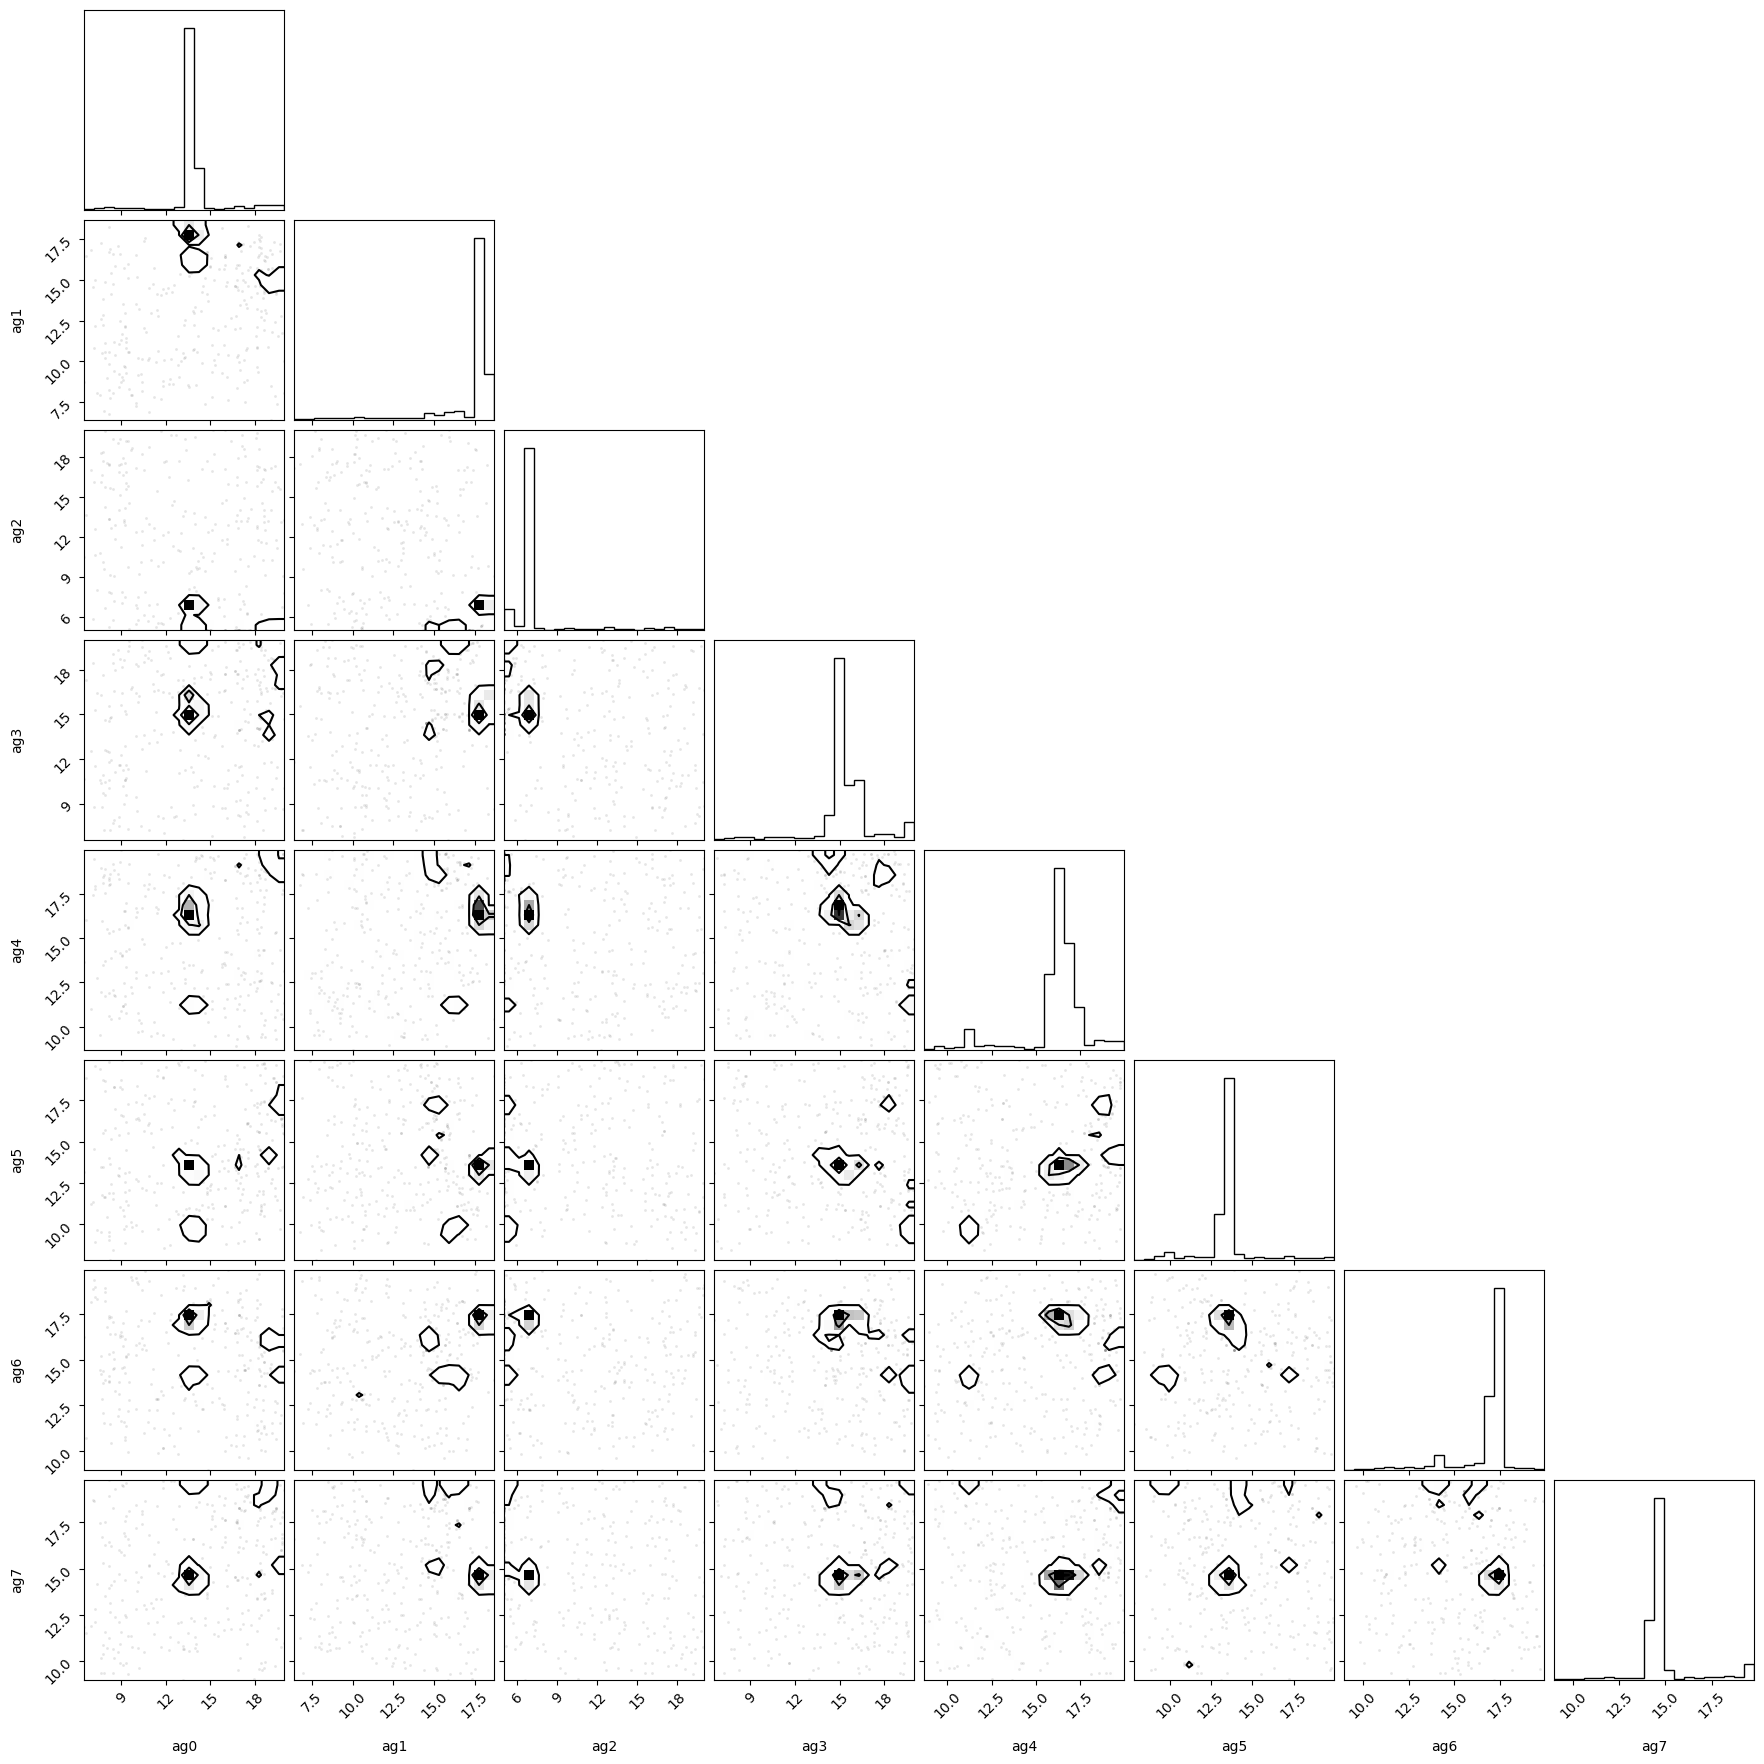

In [140]:

print(np.shape(posterior_nonh["a_g"][:,0]))
data = az.from_dict(
    posterior={"ag0": posterior_nonh["a_g"][:,0], "ag1": posterior_nonh["a_g"][:,1],
               "ag2": posterior_nonh["a_g"][:,2], "ag3": posterior_nonh["a_g"][:,3],
               "ag4": posterior_nonh["a_g"][:,4], "ag5": posterior_nonh["a_g"][:,5],
               "ag6": posterior_nonh["a_g"][:,6], "ag7": posterior_nonh["a_g"][:,7],
               },
    sample_stats={"diverging": posterior_nonh["a_g"][:,0] > 15.0},
)

figure = corner.corner(data)
                       #, divergences=True,
                       #range = [(5,20),(5,20),(5,20),(5,20),(5,20),(5,20),(5,20),(5,20)])

In [55]:
# what is going on, why is 

In [72]:
def pos_calculator_integer(L, theta, a_g, sigma, time):
    print('this is the cosine arg', np.sqrt(a_g / L), 'cosine of this', np.cos(np.sqrt(a_g / L)))
    print('this is the sine arg', theta * np.cos(np.sqrt(a_g / L)) * time, 'sine of this', np.sin(theta * np.cos(np.sqrt(a_g / L)) * time))
    pos = L * np.sin(theta * np.cos(np.sqrt(a_g / L) * time)) + sigma
    return pos

'''
theta_time = starting_angle_values * np.cos(
            np.sqrt(acceleration_values / pendulum_arm_length_values)
        )

        # Calculate x using the modified parameters and time
        return pendulum_arm_length_values * np.sin(theta_time * time)

'''
L = 10
theta = np.pi / 2
a_g = 10
sigma = 0.05
times = 0
print(pos_calculator_integer(L,theta,a_g,sigma,times))

this is the cosine arg 1.0 cosine of this 0.5403023058681398
this is the sine arg 0.0 sine of this 0.0
10.05
